In [ ]:
# models/mlp_fusion.py (Optimized for Google Colab Pro+ GPU)
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import re
import gcsfs
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
# Speed tweaks for Colab
torch.backends.cudnn.benchmark = True
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
KEY_PATH = "Key.json"
fs = gcsfs.GCSFileSystem(token=KEY_PATH)

In [ ]:
# Define features
eeg_features = ["Mobility", "Complexity", "Spectral_Entropy"]
eye_features = [
    "mean_pupil_size", "std_pupil_size",
    "mean_latency", "std_latency",
    "mean_gaze_vector", "std_gaze_vector"
]
beh_features = ["mean_rt", "accuracy"]

In [ ]:
# Data preparation pipeline
def extract_patient_id(name):
    match = re.findall(r'(A\d{5,})', str(name))
    return match[0] if match else None

In [ ]:
def load_csv(fs, path, id_col):
    with fs.open(path, 'r') as f:
        df = pd.read_csv(f)
    df["patient_id"] = df[id_col].apply(extract_patient_id)
    return df

In [ ]:
def group_features(df, features):
    return df.groupby("patient_id")[features].mean().reset_index()

In [ ]:
def impute_missing_rows(modality_df, features, missing_ids):
    avg_values = modality_df[features].mean()
    imputed = pd.DataFrame([{**{"patient_id": pid}, **avg_values.to_dict()} for pid in missing_ids])
    return pd.concat([modality_df, imputed], ignore_index=True)

In [ ]:
eeg_df = load_csv(fs, "gs://eegchild/processed_features/merged_features.csv", "file_name")
eye_df = load_csv(fs, "gs://eegchild/processed_asd_features.csv", "file_name")
beh_df = load_csv(fs, "gs://eegchild/processed_features/behavioral_features.csv", "file")
label_df = load_csv(fs, "gs://eegchild/MIPDB_PublicFile.csv", "ID")

/tmp/ipykernel_869258/1353517648.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


In [ ]:
label_df = label_df.rename(columns={"DX_Status": "diagnosis_status"})
label_df["diagnosis_status"] = label_df["diagnosis_status"].replace({2: 1})

In [ ]:
for df in [eeg_df, eye_df, beh_df, label_df]:
    df["patient_id"] = df["patient_id"].astype(str)

In [ ]:
grouped_eeg = group_features(eeg_df, eeg_features)
grouped_eye = group_features(eye_df, eye_features)
grouped_beh = group_features(beh_df, beh_features)

In [ ]:
expected_ids = set(label_df["patient_id"])
grouped_eeg = impute_missing_rows(grouped_eeg, eeg_features, expected_ids - set(grouped_eeg["patient_id"]))
grouped_eye = impute_missing_rows(grouped_eye, eye_features, expected_ids - set(grouped_eye["patient_id"]))
grouped_beh = impute_missing_rows(grouped_beh, beh_features, expected_ids - set(grouped_beh["patient_id"]))

In [ ]:
eeg_merged = grouped_eeg.merge(label_df, on="patient_id")
eye_merged = grouped_eye.merge(label_df, on="patient_id")
beh_merged = grouped_beh.merge(label_df, on="patient_id")

In [ ]:
common_ids = set(eeg_merged["patient_id"]) & set(eye_merged["patient_id"]) & set(beh_merged["patient_id"])
eeg_final = eeg_merged[eeg_merged["patient_id"].isin(common_ids)].reset_index(drop=True)
eye_final = eye_merged[eye_merged["patient_id"].isin(common_ids)].reset_index(drop=True)
beh_final = beh_merged[beh_merged["patient_id"].isin(common_ids)].reset_index(drop=True)

In [ ]:
merged_df = pd.DataFrame({"patient_id": eeg_final["patient_id"], "label": eeg_final["diagnosis_status"]})
for feat in eeg_features:
    merged_df[f"eeg_{feat}"] = eeg_final[feat]
for feat in eye_features:
    merged_df[f"eye_{feat}"] = eye_final[feat]
for feat in beh_features:
    merged_df[f"beh_{feat}"] = beh_final[feat]

In [ ]:
class_0 = merged_df[merged_df["label"] == 0]
class_1 = merged_df[merged_df["label"] == 1]
balanced_df = pd.concat([
    class_0.sample(n=63, replace=True, random_state=42),
    class_1.sample(n=63, replace=True, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
all_feature_cols = [c for c in balanced_df.columns if c.startswith("eeg_") or c.startswith("eye_") or c.startswith("beh_")]
for col in all_feature_cols:
    balanced_df[col] = pd.to_numeric(balanced_df[col], errors='coerce').fillna(0).astype(np.float32)

class MultimodalDataset(Dataset):
    def __init__(self, df):
        self.df = df.copy()
        self.eeg_cols = [c for c in self.df.columns if c.startswith("eeg_")]
        self.eye_cols = [c for c in self.df.columns if c.startswith("eye_")]
        self.beh_cols = [c for c in self.df.columns if c.startswith("beh_")]
        for c in self.eeg_cols + self.eye_cols + self.beh_cols:
            self.df[c] = pd.to_numeric(self.df[c], errors="coerce").fillna(0).astype(np.float32)
        self.df["label"] = self.df["label"].astype(int)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        eeg = torch.tensor(row[self.eeg_cols].values.astype(np.float32), dtype=torch.float32)
        eye = torch.tensor(row[self.eye_cols].values.astype(np.float32), dtype=torch.float32)
        beh = torch.tensor(row[self.beh_cols].values.astype(np.float32), dtype=torch.float32)
        label = torch.tensor(row["label"], dtype=torch.long)
        return eeg, eye, beh, label

def create_loaders(df, train_ratio=0.7, val_ratio=0.15, batch_size=16):
    train_df, temp_df = train_test_split(df, test_size=1 - train_ratio, stratify=df["label"], random_state=42)
    val_size = val_ratio / (1 - train_ratio)
    val_df, test_df = train_test_split(temp_df, test_size=1 - val_size, stratify=temp_df["label"], random_state=42)

    train_ds = MultimodalDataset(train_df)
    val_ds = MultimodalDataset(val_df)
    test_ds = MultimodalDataset(test_df)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, pin_memory=True)
    return train_loader, val_loader, test_loader

# [model + training + evaluation remains unchanged]


In [ ]:
# Add MLP model + training + evaluation (continued from previous)

class MLPFusion(nn.Module):
    def __init__(self, eeg_dim, eye_dim, beh_dim):
        super().__init__()
        self.eeg_fc = nn.Sequential(
            nn.Linear(eeg_dim, 64), nn.ReLU(), nn.Dropout(0.2)
        )
        self.eye_fc = nn.Sequential(
            nn.Linear(eye_dim, 64), nn.ReLU(), nn.Dropout(0.2)
        )
        self.beh_fc = nn.Sequential(
            nn.Linear(beh_dim, 64), nn.ReLU(), nn.Dropout(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, eeg, eye, beh):
        eeg_out = self.eeg_fc(eeg)
        eye_out = self.eye_fc(eye)
        beh_out = self.beh_fc(beh)
        fused = torch.cat([eeg_out, eye_out, beh_out], dim=1)
        return self.classifier(fused)

def train_model(model, train_loader, val_loader, device, epochs=30, lr=1e-3, patience=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    best_val_acc = 0
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for eeg, eye, beh, labels in train_loader:
            eeg, eye, beh, labels = eeg.to(device, non_blocking=True), eye.to(device, non_blocking=True), beh.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = model(eeg, eye, beh)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader, device, return_acc=True)
        print(f"[Epoch {epoch}] Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "results/best_mlp_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break
    print("Best Val Accuracy:", best_val_acc)

def evaluate_model(model, loader, device, return_acc=False):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for eeg, eye, beh, labels in loader:
            eeg, eye, beh, labels = eeg.to(device), eye.to(device), beh.to(device), labels.to(device)
            logits = model(eeg, eye, beh)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    if return_acc:
        return acc
    print(classification_report(all_labels, all_preds, zero_division=0))
    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(cm).plot()
    os.makedirs("results", exist_ok=True)
    plt.savefig("results/mlp_confmat.png")
    plt.close()

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(" Using device:", device)
    train_loader, val_loader, test_loader = create_loaders(balanced_df)

    model = MLPFusion(
        eeg_dim=len(eeg_features),
        eye_dim=len(eye_features),
        beh_dim=len(beh_features)
    ).to(device)

    train_model(model, train_loader, val_loader, device)

    model.load_state_dict(torch.load("results/best_mlp_model.pt", map_location=device))
    evaluate_model(model, test_loader, device)


 Using device: cuda
[Epoch 1] Loss: 51.9666, Train Acc: 0.4545, Val Acc: 0.5000
[Epoch 2] Loss: 53.4410, Train Acc: 0.4886, Val Acc: 0.5000
[Epoch 3] Loss: 47.3898, Train Acc: 0.5000, Val Acc: 0.5000
[Epoch 4] Loss: 42.2645, Train Acc: 0.5227, Val Acc: 0.5000
Early stopping.
Best Val Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        10
           1       0.00      0.00      0.00        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



/tmp/ipykernel_869258/2656283454.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("results/best_mlp_model.pt", map_location=device))


In [ ]:
# Add MLP model + training + evaluation (continued from previous)

from sklearn.preprocessing import StandardScaler

# Feature normalization before DataLoader creation
scaler = StandardScaler()
balanced_df[all_feature_cols] = scaler.fit_transform(balanced_df[all_feature_cols])

# Define weighted loss based on label distribution
label_counts = balanced_df['label'].value_counts().to_dict()
total = sum(label_counts.values())
weights = [total / label_counts.get(i, 1) for i in range(2)]
class_weights = torch.tensor(weights, dtype=torch.float32).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

class MLPFusion(nn.Module):
    def __init__(self, eeg_dim, eye_dim, beh_dim):
        super().__init__()
        self.eeg_fc = nn.Sequential(
            nn.Linear(eeg_dim, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.2)
        )
        self.eye_fc = nn.Sequential(
            nn.Linear(eye_dim, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.2)
        )
        self.beh_fc = nn.Sequential(
            nn.Linear(beh_dim, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 3, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, eeg, eye, beh):
        eeg_out = self.eeg_fc(eeg)
        eye_out = self.eye_fc(eye)
        beh_out = self.beh_fc(beh)
        fused = torch.cat([eeg_out, eye_out, beh_out], dim=1)
        return self.classifier(fused)

def train_model(model, train_loader, val_loader, device, epochs=50, lr=1e-3, patience=6):
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    best_val_acc = 0
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for eeg, eye, beh, labels in train_loader:
            eeg, eye, beh, labels = eeg.to(device, non_blocking=True), eye.to(device, non_blocking=True), beh.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = model(eeg, eye, beh)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader, device, return_acc=True)
        print(f"[Epoch {epoch}] Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "results/best_mlp_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break
    print("Best Val Accuracy:", best_val_acc)

def evaluate_model(model, loader, device, return_acc=False):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for eeg, eye, beh, labels in loader:
            eeg, eye, beh, labels = eeg.to(device), eye.to(device), beh.to(device), labels.to(device)
            logits = model(eeg, eye, beh)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    if return_acc:
        return acc
    print(classification_report(all_labels, all_preds, zero_division=0))
    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(cm).plot()
    os.makedirs("results", exist_ok=True)
    plt.savefig("results/mlp_confmat.png")
    plt.close()

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(" Using device:", device)
    train_loader, val_loader, test_loader = create_loaders(balanced_df)

    model = MLPFusion(
        eeg_dim=len(eeg_features),
        eye_dim=len(eye_features),
        beh_dim=len(beh_features)
    ).to(device)

    train_model(model, train_loader, val_loader, device)

    model.load_state_dict(torch.load("results/best_mlp_model.pt", map_location=device))
    evaluate_model(model, test_loader, device)


 Using device: cuda
[Epoch 1] Loss: 0.6826, Train Acc: 0.6023, Val Acc: 0.6667
[Epoch 2] Loss: 0.5742, Train Acc: 0.6705, Val Acc: 0.6667
[Epoch 3] Loss: 0.5135, Train Acc: 0.7273, Val Acc: 0.6111
[Epoch 4] Loss: 0.4937, Train Acc: 0.7614, Val Acc: 0.7222
[Epoch 5] Loss: 0.4696, Train Acc: 0.7841, Val Acc: 0.6667
[Epoch 6] Loss: 0.4717, Train Acc: 0.7727, Val Acc: 0.6667
[Epoch 7] Loss: 0.4181, Train Acc: 0.8636, Val Acc: 0.6667
[Epoch 8] Loss: 0.4582, Train Acc: 0.7614, Val Acc: 0.6667
[Epoch 9] Loss: 0.4219, Train Acc: 0.8068, Val Acc: 0.7222
[Epoch 10] Loss: 0.4167, Train Acc: 0.8409, Val Acc: 0.7222
Early stopping.
Best Val Accuracy: 0.7222222222222222
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.64      0.90      0.75        10

    accuracy                           0.70        20
   macro avg       0.74      0.70      0.69        20
weighted avg       0.74      0.70      0.69        20



/tmp/ipykernel_869258/3145037245.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("results/best_mlp_model.pt", map_location=device))


In [ ]:
# Add Gated Multimodal Unit Fusion (GMUFusion)

from sklearn.preprocessing import StandardScaler

# Feature normalization before DataLoader creation
scaler = StandardScaler()
balanced_df[all_feature_cols] = scaler.fit_transform(balanced_df[all_feature_cols])

# Define weighted loss based on label distribution
label_counts = balanced_df['label'].value_counts().to_dict()
total = sum(label_counts.values())
weights = [total / label_counts.get(i, 1) for i in range(2)]
class_weights = torch.tensor(weights, dtype=torch.float32).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

class GMUFusion(nn.Module):
    def __init__(self, eeg_dim, eye_dim, beh_dim):
        super().__init__()
        self.eeg_fc = nn.Linear(eeg_dim, 64)
        self.eye_fc = nn.Linear(eye_dim, 64)
        self.beh_fc = nn.Linear(beh_dim, 64)

        self.z_gate = nn.Sequential(
            nn.Linear(64 * 3, 64),
            nn.Sigmoid()
        )

        self.fusion_fc = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        )

    def forward(self, eeg, eye, beh):
        eeg_h = self.eeg_fc(eeg)
        eye_h = self.eye_fc(eye)
        beh_h = self.beh_fc(beh)
        concat = torch.cat([eeg_h, eye_h, beh_h], dim=1)
        z = self.z_gate(concat)
        gated = z * eeg_h + (1 - z) * eye_h + beh_h * 0.5
        return self.fusion_fc(gated)

def train_model(model, train_loader, val_loader, device, epochs=50, lr=1e-3, patience=6):
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    best_val_acc = 0
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for eeg, eye, beh, labels in train_loader:
            eeg, eye, beh, labels = eeg.to(device, non_blocking=True), eye.to(device, non_blocking=True), beh.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = model(eeg, eye, beh)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader, device, return_acc=True)
        print(f"[Epoch {epoch}] Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "results/best_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break
    print("Best Val Accuracy:", best_val_acc)

def evaluate_model(model, loader, device, return_acc=False):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for eeg, eye, beh, labels in loader:
            eeg, eye, beh, labels = eeg.to(device), eye.to(device), beh.to(device), labels.to(device)
            logits = model(eeg, eye, beh)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    if return_acc:
        return acc
    print(classification_report(all_labels, all_preds, zero_division=0))
    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(cm).plot()
    os.makedirs("results", exist_ok=True)
    plt.savefig("results/test_confmat.png")
    plt.close()

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(" Using device:", device)
    train_loader, val_loader, test_loader = create_loaders(balanced_df)

    model = GMUFusion(
        eeg_dim=len(eeg_features),
        eye_dim=len(eye_features),
        beh_dim=len(beh_features)
    ).to(device)

    train_model(model, train_loader, val_loader, device)

    model.load_state_dict(torch.load("results/best_model.pt", map_location=device))
    evaluate_model(model, test_loader, device)

 Using device: cuda
[Epoch 1] Loss: 0.6818, Train Acc: 0.5341, Val Acc: 0.6111
[Epoch 2] Loss: 0.6396, Train Acc: 0.5568, Val Acc: 0.7222
[Epoch 3] Loss: 0.6171, Train Acc: 0.6818, Val Acc: 0.8333
[Epoch 4] Loss: 0.5832, Train Acc: 0.7273, Val Acc: 0.7778
[Epoch 5] Loss: 0.5699, Train Acc: 0.7614, Val Acc: 0.7778
[Epoch 6] Loss: 0.5557, Train Acc: 0.7273, Val Acc: 0.7222
[Epoch 7] Loss: 0.5197, Train Acc: 0.7955, Val Acc: 0.6667
[Epoch 8] Loss: 0.5023, Train Acc: 0.8182, Val Acc: 0.6667
[Epoch 9] Loss: 0.4870, Train Acc: 0.8182, Val Acc: 0.7778
Early stopping.
Best Val Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.50      0.60      0.55        10
           1       0.50      0.40      0.44        10

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.49        20
weighted avg       0.50      0.50      0.49        20



/tmp/ipykernel_869258/3597319381.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("results/best_model.pt", map_location=device))


In [ ]:
# Add CrossModal Attention Fusion

from sklearn.preprocessing import StandardScaler

# Feature normalization before DataLoader creation
scaler = StandardScaler()
balanced_df[all_feature_cols] = scaler.fit_transform(balanced_df[all_feature_cols])

# Define weighted loss based on label distribution
label_counts = balanced_df['label'].value_counts().to_dict()
total = sum(label_counts.values())
weights = [total / label_counts.get(i, 1) for i in range(2)]
class_weights = torch.tensor(weights, dtype=torch.float32).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

class CrossModalAttentionFusion(nn.Module):
    def __init__(self, eeg_dim, eye_dim, beh_dim, hidden=64):
        super().__init__()
        self.eeg_fc = nn.Linear(eeg_dim, hidden)
        self.eye_fc = nn.Linear(eye_dim, hidden)
        self.beh_fc = nn.Linear(beh_dim, hidden)

        self.attn = nn.MultiheadAttention(embed_dim=hidden, num_heads=4, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(hidden, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        )

    def forward(self, eeg, eye, beh):
        eeg_h = self.eeg_fc(eeg)
        eye_h = self.eye_fc(eye)
        beh_h = self.beh_fc(beh)
        x = torch.stack([eeg_h, eye_h, beh_h], dim=1)  # shape: (B, 3, H)
        attn_output, _ = self.attn(x, x, x)
        pooled = attn_output.mean(dim=1)  # shape: (B, H)
        return self.classifier(pooled)

def train_model(model, train_loader, val_loader, device, epochs=50, lr=1e-3, patience=6):
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    best_val_acc = 0
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for eeg, eye, beh, labels in train_loader:
            eeg, eye, beh, labels = eeg.to(device, non_blocking=True), eye.to(device, non_blocking=True), beh.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = model(eeg, eye, beh)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader, device, return_acc=True)
        print(f"[Epoch {epoch}] Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "results/best_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break
    print("Best Val Accuracy:", best_val_acc)

def evaluate_model(model, loader, device, return_acc=False):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for eeg, eye, beh, labels in loader:
            eeg, eye, beh, labels = eeg.to(device), eye.to(device), beh.to(device), labels.to(device)
            logits = model(eeg, eye, beh)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    if return_acc:
        return acc
    print(classification_report(all_labels, all_preds, zero_division=0))
    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(cm).plot()
    os.makedirs("results", exist_ok=True)
    plt.savefig("results/test_confmat.png")
    plt.close()

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(" Using device:", device)
    train_loader, val_loader, test_loader = create_loaders(balanced_df)

    model = CrossModalAttentionFusion(
        eeg_dim=len(eeg_features),
        eye_dim=len(eye_features),
        beh_dim=len(beh_features)
    ).to(device)

    train_model(model, train_loader, val_loader, device)

    model.load_state_dict(torch.load("results/best_model.pt", map_location=device))
    evaluate_model(model, test_loader, device)


 Using device: cuda
[Epoch 1] Loss: 0.6846, Train Acc: 0.5341, Val Acc: 0.6111
[Epoch 2] Loss: 0.6709, Train Acc: 0.6477, Val Acc: 0.5000
[Epoch 3] Loss: 0.6430, Train Acc: 0.6705, Val Acc: 0.6111
[Epoch 4] Loss: 0.6180, Train Acc: 0.6932, Val Acc: 0.7222
[Epoch 5] Loss: 0.5841, Train Acc: 0.6932, Val Acc: 0.7778
[Epoch 6] Loss: 0.5363, Train Acc: 0.7386, Val Acc: 0.7778
[Epoch 7] Loss: 0.4859, Train Acc: 0.7500, Val Acc: 0.7778
[Epoch 8] Loss: 0.4510, Train Acc: 0.8295, Val Acc: 0.7778
[Epoch 9] Loss: 0.4134, Train Acc: 0.8182, Val Acc: 0.6111
[Epoch 10] Loss: 0.3869, Train Acc: 0.8409, Val Acc: 0.7222
[Epoch 11] Loss: 0.3597, Train Acc: 0.8636, Val Acc: 0.7222
Early stopping.
Best Val Accuracy: 0.7777777777777778
              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       0.57      0.40      0.47        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.54        20
wei

/tmp/ipykernel_869258/4029186695.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("results/best_model.pt", map_location=device))


 Using device: cuda

 Training TransformerFusion
[Epoch 1] Loss: 0.7143, Train Acc: 0.4886, Val Acc: 0.6111
[Epoch 2] Loss: 0.6424, Train Acc: 0.6705, Val Acc: 0.4444
[Epoch 3] Loss: 0.6113, Train Acc: 0.7273, Val Acc: 0.7778
[Epoch 4] Loss: 0.5643, Train Acc: 0.7386, Val Acc: 0.5000
[Epoch 5] Loss: 0.5290, Train Acc: 0.7386, Val Acc: 0.8333
[Epoch 6] Loss: 0.4453, Train Acc: 0.7727, Val Acc: 0.8333
[Epoch 7] Loss: 0.4169, Train Acc: 0.8182, Val Acc: 0.8333
[Epoch 8] Loss: 0.4207, Train Acc: 0.7727, Val Acc: 0.8889
[Epoch 9] Loss: 0.3384, Train Acc: 0.8636, Val Acc: 0.8333
[Epoch 10] Loss: 0.3079, Train Acc: 0.8523, Val Acc: 0.7778
[Epoch 11] Loss: 0.3020, Train Acc: 0.8295, Val Acc: 0.8889
[Epoch 12] Loss: 0.2474, Train Acc: 0.8864, Val Acc: 0.8889
[Epoch 13] Loss: 0.2213, Train Acc: 0.8750, Val Acc: 0.8889
[Epoch 14] Loss: 0.2800, Train Acc: 0.8523, Val Acc: 0.7778
Early stopping.
Best Val Accuracy: 0.8888888888888888
              precision    recall  f1-score   support

           

/tmp/ipykernel_869258/2908334744.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_t.load_state_dict(torch.load("results/best_model.pt", map_location=device))


[Epoch 2] Loss: 0.6500, Train Acc: 0.6023, Val Acc: 0.7778
[Epoch 3] Loss: 0.6185, Train Acc: 0.7386, Val Acc: 0.7778
[Epoch 4] Loss: 0.5936, Train Acc: 0.7273, Val Acc: 0.7778
[Epoch 5] Loss: 0.5677, Train Acc: 0.7727, Val Acc: 0.7778
[Epoch 6] Loss: 0.5450, Train Acc: 0.7614, Val Acc: 0.7778
[Epoch 7] Loss: 0.5210, Train Acc: 0.7955, Val Acc: 0.6667
[Epoch 8] Loss: 0.4990, Train Acc: 0.8182, Val Acc: 0.7222
Early stopping.
Best Val Accuracy: 0.7777777777777778
              precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.60      0.90      0.72        10

    accuracy                           0.65        20
   macro avg       0.70      0.65      0.63        20
weighted avg       0.70      0.65      0.63        20



/tmp/ipykernel_869258/2908334744.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_g.load_state_dict(torch.load("results/best_model.pt", map_location=device))


In [ ]:
# Further Analysis for TransformerFusion and GATFusion
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# Self-Attention Heatmap Visualizer (Transformer)
@torch.no_grad()
def visualize_attention_weights(model, eeg, eye, beh):
    model.eval()
    device = next(model.parameters()).device
    eeg = eeg.to(device).unsqueeze(0)
    eye = eye.to(device).unsqueeze(0)
    beh = beh.to(device).unsqueeze(0)

    eeg_h = F.relu(model.eeg_fc(eeg))
    eye_h = F.relu(model.eye_fc(eye))
    beh_h = F.relu(model.beh_fc(beh))
    x = torch.stack([eeg_h, eye_h, beh_h], dim=1)

    attn_layer = model.transformer.layers[0].self_attn
    attn_output, attn_weights = attn_layer(x, x, x, need_weights=True)
    weights = attn_weights.squeeze(0).cpu().detach().numpy()

    for h in range(weights.shape[0]):
        visualize_connectogram(weights[h], title=f"Transformer Head {h+1} Connectogram", save_path=f"results/transformer_connectogram_{h+1}.png")

# GAT attention visualizer
@torch.no_grad()
def visualize_gat_attention(model, eeg, eye, beh):
    model.eval()
    device = next(model.parameters()).device
    eeg = eeg.to(device).unsqueeze(0)
    eye = eye.to(device).unsqueeze(0)
    beh = beh.to(device).unsqueeze(0)

    eeg_h = F.relu(model.eeg_fc(eeg))
    eye_h = F.relu(model.eye_fc(eye))
    beh_h = F.relu(model.beh_fc(beh))
    x = torch.stack([eeg_h, eye_h, beh_h], dim=1)

    h = model.gat.lin(x)
    att_src = model.gat.att_src.view(1, 1, -1)
    att_dst = model.gat.att_dst.view(1, 1, -1)

    src = (h * att_src).sum(dim=-1)
    dst = (h * att_dst).sum(dim=-1)
    e = model.gat.leaky_relu(src.unsqueeze(2) + dst.unsqueeze(1))
    alpha = F.softmax(e, dim=-1).squeeze(0).cpu().numpy()

    visualize_connectogram(alpha, title="GAT Connectogram", save_path="results/gat_connectogram.png")

# Connectogram-Style Visualization
def visualize_connectogram(matrix, title="Connectogram", save_path="connectogram.png"):
    matrix = np.asarray(matrix)
    if matrix.ndim == 1:
        matrix = np.expand_dims(matrix, axis=0)
    if matrix.shape != (3, 3):
        print(f"Invalid shape for matrix: {matrix.shape}, skipping plot.")
        return

    labels = ["EEG", "Eye", "Beh"]
    pos = {
        "EEG": (0, 1),
        "Eye": (-1, -1),
        "Beh": (1, -1)
    }
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.axis('off')

    for label in labels:
        x, y = pos[label]
        circle = Circle((x, y), 0.15, color='skyblue', ec='black', lw=1.5)
        ax.add_patch(circle)
        ax.text(x, y, label, fontsize=12, ha='center', va='center', weight='bold')

    for i, src in enumerate(labels):
        for j, tgt in enumerate(labels):
            if i != j:
                x1, y1 = pos[src]
                x2, y2 = pos[tgt]
                if matrix.ndim == 2:
                    weight = matrix[i][j]
                    arrow = FancyArrowPatch((x1, y1), (x2, y2), connectionstyle="arc3,rad=0.2",
                                            arrowstyle='-|>', mutation_scale=15,
                                            lw=weight * 5, color=plt.cm.viridis(weight))
                    ax.add_patch(arrow)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# Per-Modality Ablation Evaluation
@torch.no_grad()
def ablation_test(model_class, base_model, device):
    test_results = {}

    for combo in ["eeg", "eye", "beh", "eeg+eye", "eeg+beh", "eye+beh", "all"]:
        model = model_class(len(eeg_features), len(eye_features), len(beh_features)).to(device)
        model.load_state_dict(base_model.state_dict())
        model.eval()

        all_preds, all_labels = [], []
        for eeg, eye, beh, labels in test_loader:
            eeg, eye, beh, labels = eeg.to(device), eye.to(device), beh.to(device), labels.to(device)

            if combo == "all":
                pass
            elif combo == "eeg":
                eye = torch.zeros_like(eye)
                beh = torch.zeros_like(beh)
            elif combo == "eye":
                eeg = torch.zeros_like(eeg)
                beh = torch.zeros_like(beh)
            elif combo == "beh":
                eeg = torch.zeros_like(eeg)
                eye = torch.zeros_like(eye)
            elif combo == "eeg+eye":
                beh = torch.zeros_like(beh)
            elif combo == "eeg+beh":
                eye = torch.zeros_like(eye)
            elif combo == "eye+beh":
                eeg = torch.zeros_like(eeg)

            outputs = model(eeg, eye, beh)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        cm = confusion_matrix(all_labels, all_preds)
        acc = np.mean(np.array(all_preds) == np.array(all_labels))
        report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
        test_results[combo] = {"acc": acc, "f1": report["macro avg"]["f1-score"]}

    return test_results

# Additional visualizations: ROC and PR Curve
@torch.no_grad()
def plot_roc_pr_curves(model, loader, device, title_prefix="model"):
    model.eval()
    all_labels = []
    all_probs = []

    for eeg, eye, beh, labels in loader:
        eeg, eye, beh = eeg.to(device), eye.to(device), beh.to(device)
        outputs = model(eeg, eye, beh)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.numpy())

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    prec, rec, _ = precision_recall_curve(all_labels, all_probs)

    roc_auc = auc(fpr, tpr)
    pr_auc = auc(rec, prec)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title_prefix} ROC Curve')
    plt.legend(loc='lower right')
    plt.savefig(f"results/{title_prefix.lower()}_roc.png")
    plt.close()

    plt.figure()
    plt.plot(rec, prec, label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{title_prefix} Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.savefig(f"results/{title_prefix.lower()}_pr.png")
    plt.close()

if __name__ == "__main__":
    eeg, eye, beh, label = next(iter(test_loader))
    visualize_attention_weights(model_t, eeg[0], eye[0], beh[0])
    ablation_scores = ablation_test(TransformerFusion, model_t, device)
    print("\n▶ Transformer Ablation Study Results:")
    for k, v in ablation_scores.items():
        print(f"{k.upper():9} — Accuracy: {v['acc']:.2f}, F1: {v['f1']:.2f}")

    if 'model_gat' in globals():
        visualize_gat_attention(model_gat, eeg[0], eye[0], beh[0])
        plot_roc_pr_curves(model_gat, test_loader, device, title_prefix="GAT")

    plot_roc_pr_curves(model_t, test_loader, device, title_prefix="Transformer")


Invalid shape for matrix: (1, 3), skipping plot.
Invalid shape for matrix: (1, 3), skipping plot.
Invalid shape for matrix: (1, 3), skipping plot.

▶ Transformer Ablation Study Results:
EEG       — Accuracy: 0.60, F1: 0.52
EYE       — Accuracy: 0.65, F1: 0.65
BEH       — Accuracy: 0.65, F1: 0.60
EEG+EYE   — Accuracy: 0.70, F1: 0.70
EEG+BEH   — Accuracy: 0.65, F1: 0.60
EYE+BEH   — Accuracy: 0.75, F1: 0.75
ALL       — Accuracy: 0.80, F1: 0.80


In [ ]:
#ImprovedTransformerFusion (after TransformerFusion block)
# Improved version of TransformerFusion with deeper encoding and attention fusion
class ModalityEncoder(nn.Module):
    def __init__(self, input_dim, model_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, model_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(model_dim, model_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

    def forward(self, x):
        return self.encoder(x)

class AttentionFusion(nn.Module):
    def __init__(self, model_dim):
        super().__init__()
        self.attn_weights = nn.Linear(model_dim, 1)

    def forward(self, xs):  # xs is a list of modality embeddings [B, D]
        x = torch.stack(xs, dim=1)  # Shape: (B, M, D)
        scores = self.attn_weights(x).squeeze(-1)  # Shape: (B, M)
        w = F.softmax(scores, dim=1).unsqueeze(-1)  # Shape: (B, M, 1)
        return (x * w).sum(dim=1)  # Fused output shape: (B, D)

class ImprovedTransformerFusion(nn.Module):
    def __init__(self, eeg_dim, eye_dim, beh_dim, model_dim=64):
        super().__init__()
        self.eeg_encoder = ModalityEncoder(eeg_dim, model_dim)
        self.eye_encoder = ModalityEncoder(eye_dim, model_dim)
        self.beh_encoder = ModalityEncoder(beh_dim, model_dim)

        self.fusion = AttentionFusion(model_dim)

        self.classifier = nn.Sequential(
            nn.Linear(model_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)
        )

    def forward(self, eeg, eye, beh):
        eeg_h = self.eeg_encoder(eeg)
        eye_h = self.eye_encoder(eye)
        beh_h = self.beh_encoder(beh)
        fused = self.fusion([eeg_h, eye_h, beh_h])
        return self.classifier(fused)


In [ ]:
model_improved = ImprovedTransformerFusion(
    eeg_dim=len(eeg_features),
    eye_dim=len(eye_features),
    beh_dim=len(beh_features)
).to(device)

train_model(model_improved, train_loader, val_loader, device)
model_improved.load_state_dict(torch.load("results/best_model.pt", map_location=device))
evaluate_model(model_improved, test_loader, device)


[Epoch 1] Loss: 0.6964, Train Acc: 0.5000, Val Acc: 0.5000
[Epoch 2] Loss: 0.6889, Train Acc: 0.4886, Val Acc: 0.5000
[Epoch 3] Loss: 0.6892, Train Acc: 0.5114, Val Acc: 0.5556
[Epoch 4] Loss: 0.6761, Train Acc: 0.6364, Val Acc: 0.6667
[Epoch 5] Loss: 0.6723, Train Acc: 0.5227, Val Acc: 0.6667
[Epoch 6] Loss: 0.6577, Train Acc: 0.6364, Val Acc: 0.6667
[Epoch 7] Loss: 0.6480, Train Acc: 0.6477, Val Acc: 0.7222
[Epoch 8] Loss: 0.6390, Train Acc: 0.6591, Val Acc: 0.7222
[Epoch 9] Loss: 0.6225, Train Acc: 0.6705, Val Acc: 0.8889
[Epoch 10] Loss: 0.5937, Train Acc: 0.7955, Val Acc: 0.8889
[Epoch 11] Loss: 0.5561, Train Acc: 0.7273, Val Acc: 0.8889
[Epoch 12] Loss: 0.5438, Train Acc: 0.7614, Val Acc: 0.8333
[Epoch 13] Loss: 0.5213, Train Acc: 0.7614, Val Acc: 0.8889
[Epoch 14] Loss: 0.4869, Train Acc: 0.7159, Val Acc: 0.7778
[Epoch 15] Loss: 0.4650, Train Acc: 0.7727, Val Acc: 0.7778
Early stopping.
Best Val Accuracy: 0.8888888888888888
              precision    recall  f1-score   support



/tmp/ipykernel_869258/242916466.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_improved.load_state_dict(torch.load("results/best_model.pt", map_location=device))


In [ ]:
"""
[NEW] Modality Embedding Layer — to embed modality-type tokens, improving cross-modal attention.

[NEW] Learnable Positional Embeddings — optional but may benefit stability with small batch sizes.

[MODIFIED] Early Layer Normalization — TransformerEncoderLayer in PyTorch uses pre-LN style.

[MODIFIED] Deeper Classification Head — more expressive capacity, with regularization.
"""

'\n[NEW] Modality Embedding Layer — to embed modality-type tokens, improving cross-modal attention.\n\n[NEW] Learnable Positional Embeddings — optional but may benefit stability with small batch sizes.\n\n[MODIFIED] Early Layer Normalization — TransformerEncoderLayer in PyTorch uses pre-LN style.\n\n[MODIFIED] Deeper Classification Head — more expressive capacity, with regularization.\n'

In [ ]:
class TransformerFusionBlock(nn.Module):
    def __init__(self, model_dim=32, nhead=4):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=nhead, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.attn_weights = nn.Parameter(torch.ones(3))

    def forward(self, modalities):
        x = torch.stack(modalities, dim=1)
        x = self.transformer(x)
        weights = torch.softmax(self.attn_weights, dim=0)
        return (x * weights.view(1, -1, 1)).sum(dim=1)

class ImprovedTransformerFusion(nn.Module):
    def __init__(self, eeg_dim, eye_dim, beh_dim, model_dim=32):
        super().__init__()
        self.eeg_encoder = ModalityEncoder(eeg_dim, model_dim)
        self.eye_encoder = ModalityEncoder(eye_dim, model_dim)
        self.beh_encoder = ModalityEncoder(beh_dim, model_dim)
        self.fusion = TransformerFusionBlock(model_dim=model_dim)
        self.classifier = nn.Sequential(
            nn.Linear(model_dim, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 1)
        )

    def forward(self, eeg, eye, beh):
        x_eeg = self.eeg_encoder(eeg)
        x_eye = self.eye_encoder(eye)
        x_beh = self.beh_encoder(beh)
        fused = self.fusion([x_eeg, x_eye, x_beh])
        return self.classifier(fused)

# Instantiate the improved model
model = ImprovedTransformerFusion(
    eeg_dim=len(EEG_FEATURES),
    eye_dim=len(EYE_FEATURES),
    beh_dim=len(BEHAV_FEATURES)
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


In [ ]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-4)


In [ ]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss, correct, count = 0, 0, 0
    all_labels, all_probs = [], []
    with torch.no_grad():
        for eeg, eye, beh, labels in dataloader:
            eeg, eye, beh, labels = eeg.to(device), eye.to(device), beh.to(device), labels.to(device).unsqueeze(1).float()
            outputs = model(eeg, eye, beh)
            loss = criterion(outputs, labels)
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).int()
            total_loss += loss.item() * labels.size(0)
            correct += (preds == labels.int()).sum().item()
            count += labels.size(0)
            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())
    return total_loss / count, correct / count, torch.cat(all_labels), torch.cat(all_probs)


In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, correct, count = 0, 0, 0
    for eeg, eye, beh, labels in dataloader:
        eeg, eye, beh, labels = eeg.to(device), eye.to(device), beh.to(device), labels.to(device).unsqueeze(1).float()
        optimizer.zero_grad()
        outputs = model(eeg, eye, beh)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        preds = (torch.sigmoid(outputs) >= 0.5).int()
        correct += (preds == labels.int()).sum().item()
        count += labels.size(0)
    return total_loss / count, correct / count


In [ ]:
from sklearn.metrics import classification_report
import copy

best_acc = 0
best_model = None
patience, counter = 5, 0

for epoch in range(30):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_labels, val_probs = evaluate(model, val_loader, criterion)

    print(f"[Epoch {epoch+1}] Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping.")
            break


[Epoch 1] Loss: 0.6963, Train Acc: 0.5227, Val Acc: 0.5556
[Epoch 2] Loss: 0.6902, Train Acc: 0.5682, Val Acc: 0.6667
[Epoch 3] Loss: 0.6885, Train Acc: 0.5909, Val Acc: 0.5556
[Epoch 4] Loss: 0.6803, Train Acc: 0.5795, Val Acc: 0.6111
[Epoch 5] Loss: 0.6891, Train Acc: 0.5000, Val Acc: 0.9444
[Epoch 6] Loss: 0.6820, Train Acc: 0.5568, Val Acc: 0.8333
[Epoch 7] Loss: 0.6740, Train Acc: 0.6250, Val Acc: 0.7778
[Epoch 8] Loss: 0.6819, Train Acc: 0.5909, Val Acc: 0.7222
[Epoch 9] Loss: 0.6781, Train Acc: 0.5909, Val Acc: 0.7778
[Epoch 10] Loss: 0.6756, Train Acc: 0.6023, Val Acc: 0.6667
Early stopping.


In [ ]:
model.load_state_dict(best_model)
test_loss, test_acc, test_labels, test_probs = evaluate(model, test_loader, criterion)
test_preds = (test_probs >= 0.5).int()
print("\nTest Classification Report:")
print(classification_report(test_labels, test_preds, digits=4))



Test Classification Report:
              precision    recall  f1-score   support

         0.0     0.5455    0.6000    0.5714        10
         1.0     0.5556    0.5000    0.5263        10

    accuracy                         0.5500        20
   macro avg     0.5505    0.5500    0.5489        20
weighted avg     0.5505    0.5500    0.5489        20



In [ ]:
# -*- coding: utf-8 -*-
"""
Updated NeuroXplain Pipeline - Further Improved Transformer Fusion Model with Dynamic Layer Depth, Weighted Sampling, Adaptive Optimizer,
Label Smoothing, Bias Mitigation (Pre-, In-, and Post-Processing), and Responsible AI Additions
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import re
import gcsfs
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import shap

# Speed tweaks
torch.backends.cudnn.benchmark = True
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Auth
KEY_PATH = "Key.json"
fs = gcsfs.GCSFileSystem(token=KEY_PATH)

# Features
EEG_FEATURES = ["Mobility", "Complexity", "Spectral_Entropy"]
EYE_FEATURES = [
    "mean_pupil_size", "std_pupil_size",
    "mean_latency", "std_latency",
    "mean_gaze_vector", "std_gaze_vector"
]
BEHAV_FEATURES = ["mean_rt", "accuracy"]

# ----------------------------
# ?? Transformer Model Block
# ----------------------------
class ModalityEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

    def forward(self, x):
        return self.net(x)

class TransformerFusionBlock(nn.Module):
    def __init__(self, model_dim=32, nhead=4, num_layers=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=nhead, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.attn_weights = nn.Parameter(torch.ones(3))

    def forward(self, modalities):
        x = torch.stack(modalities, dim=1)
        x = self.transformer(x)
        weights = torch.softmax(self.attn_weights, dim=0)
        return (x * weights.view(1, -1, 1)).sum(dim=1)

class ImprovedTransformerFusion(nn.Module):
    def __init__(self, eeg_dim, eye_dim, beh_dim, model_dim=32):
        super().__init__()
        self.eeg_encoder = ModalityEncoder(eeg_dim, model_dim)
        self.eye_encoder = ModalityEncoder(eye_dim, model_dim)
        self.beh_encoder = ModalityEncoder(beh_dim, model_dim)
        self.fusion = TransformerFusionBlock(model_dim=model_dim, num_layers=2)
        self.classifier = nn.Sequential(
            nn.Linear(model_dim, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 1)
        )

    def forward(self, eeg, eye, beh):
        x_eeg = self.eeg_encoder(eeg)
        x_eye = self.eye_encoder(eye)
        x_beh = self.beh_encoder(beh)
        fused = self.fusion([x_eeg, x_eye, x_beh])
        return self.classifier(fused)

# ----------------------------
# ? Updated Focal Loss with Label Smoothing
# ----------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, smoothing=0.1, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smoothing = smoothing
        self.reduction = reduction

    def forward(self, inputs, targets):
        targets = targets * (1.0 - self.smoothing) + 0.5 * self.smoothing
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# ----------------------------
# ?? Training with Bias Mitigation and RAI Additions
# ----------------------------
def train_model(model, train_loader, val_loader, patience=6, epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = FocalLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    best_val_acc = 0
    best_model = None
    patience_counter = 0
    train_losses, val_accuracies, all_preds, all_labels = [], [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for eeg, eye, beh, labels in train_loader:
            eeg, eye, beh, labels = eeg.to(device), eye.to(device), beh.to(device), labels.float().to(device).unsqueeze(1)
            outputs = model(eeg, eye, beh)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pred = torch.sigmoid(outputs).detach().cpu().numpy() >= 0.5
            correct += (pred == labels.cpu().numpy()).sum()
            total += labels.size(0)

        train_acc = correct / total
        train_losses.append(total_loss / len(train_loader))

        # Validation
        model.eval()
        correct, total = 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for eeg, eye, beh, labels in val_loader:
                eeg, eye, beh, labels = eeg.to(device), eye.to(device), beh.to(device), labels.float().to(device).unsqueeze(1)
                outputs = model(eeg, eye, beh)
                probs = torch.sigmoid(outputs)
                preds = probs.cpu().numpy() >= 0.5
                all_preds.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                correct += (preds == labels.cpu().numpy()).sum()
                total += labels.size(0)

        val_acc = correct / total
        val_accuracies.append(val_acc)
        print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break

    model.load_state_dict(best_model)

    # PR Curve
    precision, recall, _ = precision_recall_curve(all_labels, all_preds)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.savefig("results/precision_recall_curve.png")
    plt.close()

    # Calibration Curve (Post-Processing Bias Check)
    prob_true, prob_pred = calibration_curve(np.array(all_labels).flatten(), np.array(all_preds).flatten(), n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title('Calibration Curve')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.grid(True)
    plt.savefig("results/calibration_curve.png")
    plt.close()

    return model


In [ ]:
!pip install fairlearn

/bin/bash: /home/ayesha/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
# -*- coding: utf-8 -*-
"""
Updated NeuroXplain Pipeline - Final Evaluation + SHAP Fix + Bias Mitigation
"""

# (Existing imports remain unchanged)
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import re
import gcsfs
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import shap
from fairlearn.postprocessing import ThresholdOptimizer

# (Model, loss, and training definitions remain unchanged)

# ----------------------------
# ? Evaluation Utility
# ----------------------------
def evaluate_model(model, loader, device):
    model.eval()
    all_labels, all_preds = [], []
    criterion = FocalLoss()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for eeg, eye, beh, labels in loader:
            eeg, eye, beh, labels = eeg.to(device), eye.to(device), beh.to(device), labels.float().to(device).unsqueeze(1)
            outputs = model(eeg, eye, beh)
            loss = criterion(outputs, labels)
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).int()
            total_loss += loss.item()
            correct += (preds == labels.int()).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.detach().cpu().numpy())

    acc = correct / total
    preds_final = (np.array(all_preds) >= 0.5).astype(int)
    print(classification_report(np.array(all_labels), preds_final, digits=4))

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(all_labels, all_preds)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.savefig("results/precision_recall_curve.png")
    plt.close()

    # Calibration Curve
    prob_true, prob_pred = calibration_curve(np.array(all_labels).flatten(), np.array(all_preds).flatten(), n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title('Calibration Curve')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.grid(True)
    plt.savefig("results/calibration_curve.png")
    plt.close()

    # Save predictions
    pd.DataFrame({"label": all_labels, "pred_prob": np.array(all_preds).flatten(), "pred": preds_final.flatten()}).to_csv("results/test_predictions.csv", index=False)

    return acc, all_labels, all_preds

# ----------------------------
# ?? SHAP Explainability with Fix (detach numpy)
# ----------------------------
def explain_with_shap(model, loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    eeg_sample, eye_sample, beh_sample, _ = next(iter(loader))
    eeg_sample = eeg_sample[:50].to(device)
    eye_sample = eye_sample[:50].to(device)
    beh_sample = beh_sample[:50].to(device)

    def model_forward(X):
        eeg_len = eeg_sample.shape[1]
        eye_len = eye_sample.shape[1]
        beh_len = beh_sample.shape[1]
        eeg = torch.tensor(X[:, :eeg_len]).float().to(device)
        eye = torch.tensor(X[:, eeg_len:eeg_len+eye_len]).float().to(device)
        beh = torch.tensor(X[:, -beh_len:]).float().to(device)
        return torch.sigmoid(model(eeg, eye, beh)).detach().cpu().numpy()

    combined_input = torch.cat([eeg_sample.cpu(), eye_sample.cpu(), beh_sample.cpu()], dim=1).numpy()
    explainer = shap.KernelExplainer(model_forward, combined_input)
    shap_values = explainer.shap_values(combined_input)

    all_features = [f"eeg_{f}" for f in EEG_FEATURES] + [f"eye_{f}" for f in EYE_FEATURES] + [f"beh_{f}" for f in BEHAV_FEATURES]
    try:
        if isinstance(shap_values, list) and len(shap_values) == 1:
            shap.summary_plot(shap_values[0], combined_input, feature_names=all_features)
        else:
            shap.summary_plot(shap_values, combined_input, feature_names=all_features)
    except Exception as e:
        print("? SHAP summary_plot failed:", e)

    np.save("results/shap_values.npy", shap_values)
    np.save("results/shap_input.npy", combined_input)

# ----------------------------
# ?? Main Execution
# ----------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Prepare data
    train_loader, val_loader, test_loader = create_loaders(balanced_df)

    # Initialize model
    model = ImprovedTransformerFusion(
        eeg_dim=len(EEG_FEATURES),
        eye_dim=len(EYE_FEATURES),
        beh_dim=len(BEHAV_FEATURES),
        model_dim=32
    ).to(device)

    # Train model

#  Use the fitted internal estimator from Fairlearn
trained_model = fair_clf._trained_predictor

# Safe sample (small to avoid memory issues)
shap_sample = X_train[:50]

# Build SHAP explainer
explainer = shap.Explainer(trained_model.predict, shap_sample)

# Compute SHAP values on test subset
shap_values = explainer(X_test[:50])

# Feature names (from earlier)
feature_names = feature_cols

# Plot SHAP summary (fixes dimension mismatch errors)
shap.summary_plot(shap_values.values, X_test[:50], feature_names=feature_names)
    # Evaluate
    print("\n?? Final Test Performance:")
    acc, labels, preds = evaluate_model(trained_model, test_loader, device)

    # Fairness Post-Processing: Threshold Optimizer Placeholder
    try:
        y_true = np.array(labels).flatten()
        y_probs = np.array(preds).flatten()
        threshold_optimizer = ThresholdOptimizer(
            estimator=None, prefit=False, constraints="equalized_odds"
        )
        print("\n??  Post-processing bias mitigation via ThresholdOptimizer could be added here if groups are defined.")
    except Exception as e:
        print("ThresholdOptimizer skipped (setup issue):", e)

    # Explain
    print("\n?? Generating SHAP explainability report...")
    explain_with_shap(trained_model, test_loader)

    # Preview predictions
    df_preds = pd.read_csv("results/test_predictions.csv")
    print("\n?? Sample Predictions:")
    print(df_preds.head(10))


IndentationError: unexpected indent (252316705.py, line 151)

In [ ]:
import pandas as pd

# Re-defining demographic info due to kernel reset
group_data = {
    "6-9": {
        "male": [
            "A00053375", "A00053480", "A00054400", "A00054488", "A00054673", "A00054766", "A00054836",
            "A00054917", "A00055436", "A00055904", "A00055497", "A00054569", "A00054666", "A00055473",
            "A00056002", "A00056257", "A00056693"
        ],
        "female": [
            "A00054432", "A00055424", "A00055397", "A00054597", "A00055526", "A00055628", "A00055547"
        ]
    },
    "10-11": {
        "male": [
            "A00051826", "A00053460", "A00054517", "A00054592", "A00055392", "A00055429", "A00055613",
            "A00055623", "A00055649", "A00056428", "A00058596", "A00055469", "A00055486"
        ],
        "female": [
            "A00054535", "A00054748", "A00055293", "A00054287", "A00055038", "A00055510", "A00055616"
        ]
    },
    "12-13": {
        "male": [
            "A00051886", "A00051955", "A00053398", "A00053440", "A00053909", "A00054239", "A00054417",
            "A00055540", "A00057135", "A00054907", "A00055662", "A00055682", "A00055731", "A00055745",
            "A00055753", "A00059063"
        ],
        "female": [
            "A00055801", "A00057599", "A00054359", "A00054469", "A00054721", "A00054852"
        ]
    },
    "14-17": {
        "male": [
            "A00054817", "A00055055", "A00055077", "A00056054", "A00056116", "A00055730", "A00055085",
            "A00055978", "A00054647", "A00055482", "A00055502", "A00055486", "A00055853", "A00056733",
            "A00054623", "A00055865", "A00056158"
        ],
        "female": [
            "A00054369", "A00056723", "A00055103", "A00055837", "A00055593", "A00056166", "A00056990"
        ]
    },
    "18-24": {
        "male": [
            "A00054930", "A00055065", "A00054039", "A00057092", "A00062919", "A00058775", "A00053990",
            "A00054023"
        ],
        "female": [
            "A00054387", "A00054207", "A00054122", "A00056640", "A00059083", "A00063051", "A00056604", "A00063117"
        ]
    },
    "25-44": {
        "male": [
            "A00062219", "A00062408", "A00062125", "A00062578", "A00062704", "A00062029", "A00062435",
            "A00062951", "A00063029", "A00062279"
        ],
        "female": [
            "A00062842", "A00062453", "A00062329", "A00063558", "A00062165", "A00063377", "A00062055"
        ]
    }
}

# Flatten to dataframe
records = []
for age_group, genders in group_data.items():
    for gender, ids in genders.items():
        for pid in ids:
            records.append({
                "patient_id": pid,
                "age_group": age_group,
                "gender": gender
            })

df_demo = pd.DataFrame(records)
df_demo

,patient_id,age_group,gender
0,A00053375,6-9,male
1,A00053480,6-9,male
2,A00054400,6-9,male
3,A00054488,6-9,male
4,A00054673,6-9,male
...,...,...,...
118,A00062329,25-44,female
119,A00063558,25-44,female
120,A00062165,25-44,female
121,A00063377,25-44,female


In [ ]:
# -*- coding: utf-8 -*-
"""
Updated NeuroXplain Pipeline - Final Evaluation + SHAP Fix + Bias Mitigation + Demographics Integration + Fairness Evaluation + Threshold Optimizer + Adversarial Debiasing
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import re
import gcsfs
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, accuracy_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import shap
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate

# ----------------------------
# ? Demographic Mapping
# ----------------------------
patient_demographics = {
    "A00053375": ("6-9", "M"), "A00053480": ("6-9", "M"), "A00054400": ("6-9", "M"), "A00054488": ("6-9", "M"),
    "A00054673": ("6-9", "M"), "A00054766": ("6-9", "M"), "A00054836": ("6-9", "M"), "A00054917": ("6-9", "M"),
    "A00055436": ("6-9", "M"), "A00055904": ("6-9", "M"), "A00055497": ("6-9", "M"), "A00054569": ("6-9", "M"),
    "A00054666": ("6-9", "M"), "A00055473": ("6-9", "M"), "A00056002": ("6-9", "M"), "A00056257": ("6-9", "M"),
    "A00056693": ("6-9", "M"), "A00054432": ("6-9", "F"), "A00055424": ("6-9", "F"), "A00055397": ("6-9", "F"),
    "A00054597": ("6-9", "F"), "A00055526": ("6-9", "F"), "A00055628": ("6-9", "F"), "A00055547": ("6-9", "F"),

    "A00051826": ("10-11", "M"), "A00053460": ("10-11", "M"), "A00054517": ("10-11", "M"), "A00054592": ("10-11", "M"),
    "A00055392": ("10-11", "M"), "A00055429": ("10-11", "M"), "A00055613": ("10-11", "M"), "A00055623": ("10-11", "M"),
    "A00055649": ("10-11", "M"), "A00056428": ("10-11", "M"), "A00058596": ("10-11", "M"), "A00055469": ("10-11", "M"),
    "A00055486": ("10-11", "M"), "A00054535": ("10-11", "F"), "A00054748": ("10-11", "F"), "A00055293": ("10-11", "F"),
    "A00054287": ("10-11", "F"), "A00055038": ("10-11", "F"), "A00055510": ("10-11", "F"), "A00055616": ("10-11", "F"),

    "A00051886": ("12-13", "M"), "A00051955": ("12-13", "M"), "A00053398": ("12-13", "M"), "A00053440": ("12-13", "M"),
    "A00053909": ("12-13", "M"), "A00054239": ("12-13", "M"), "A00054417": ("12-13", "M"), "A00055540": ("12-13", "M"),
    "A00057135": ("12-13", "M"), "A00054907": ("12-13", "M"), "A00055662": ("12-13", "M"), "A00055682": ("12-13", "M"),
    "A00055731": ("12-13", "M"), "A00055745": ("12-13", "M"), "A00055753": ("12-13", "M"), "A00059063": ("12-13", "M"),
    "A00055801": ("12-13", "F"), "A00057599": ("12-13", "F"), "A00054359": ("12-13", "F"), "A00054469": ("12-13", "F"),
    "A00054721": ("12-13", "F"), "A00054852": ("12-13", "F"),

    "A00054817": ("14-17", "M"), "A00055055": ("14-17", "M"), "A00055077": ("14-17", "M"), "A00056054": ("14-17", "M"),
    "A00056116": ("14-17", "M"), "A00055730": ("14-17", "M"), "A00055085": ("14-17", "M"), "A00055978": ("14-17", "M"),
    "A00054647": ("14-17", "M"), "A00055482": ("14-17", "M"), "A00055502": ("14-17", "M"), "A00055853": ("14-17", "M"),
    "A00056733": ("14-17", "M"), "A00054623": ("14-17", "M"), "A00055865": ("14-17", "M"), "A00056158": ("14-17", "M"),
    "A00054369": ("14-17", "F"), "A00056723": ("14-17", "F"), "A00055103": ("14-17", "F"), "A00055837": ("14-17", "F"),
    "A00055593": ("14-17", "F"), "A00056166": ("14-17", "F"), "A00056990": ("14-17", "F"),

    "A00054930": ("18-24", "M"), "A00055065": ("18-24", "M"), "A00054039": ("18-24", "M"), "A00057092": ("18-24", "M"),
    "A00062919": ("18-24", "M"), "A00058775": ("18-24", "M"), "A00053990": ("18-24", "M"), "A00054023": ("18-24", "M"),
    "A00054387": ("18-24", "F"), "A00054207": ("18-24", "F"), "A00054122": ("18-24", "F"), "A00056640": ("18-24", "F"),
    "A00059083": ("18-24", "F"), "A00063051": ("18-24", "F"), "A00056604": ("18-24", "F"), "A00063117": ("18-24", "F"),

    "A00062219": ("25-44", "M"), "A00062408": ("25-44", "M"), "A00062125": ("25-44", "M"), "A00062578": ("25-44", "M"),
    "A00062704": ("25-44", "M"), "A00062029": ("25-44", "M"), "A00062435": ("25-44", "M"), "A00062951": ("25-44", "M"),
    "A00063029": ("25-44", "M"), "A00062279": ("25-44", "M"), "A00062842": ("25-44", "F"), "A00062453": ("25-44", "F"),
    "A00062329": ("25-44", "F"), "A00063558": ("25-44", "F"), "A00062165": ("25-44", "F"), "A00063377": ("25-44", "F"),
    "A00062055": ("25-44", "F")
}

def add_demographics(df):
    df['age_group'] = df['patient_id'].map(lambda x: patient_demographics.get(x, (None, None))[0])
    df['gender'] = df['patient_id'].map(lambda x: patient_demographics.get(x, (None, None))[1])
    return df

In [ ]:
# ----------------------------
# ? Helper: Evaluate by Group
# ----------------------------
def evaluate_by_group(y_true, y_pred, df, group_col):
    y_pred = np.array(y_pred).flatten()
    df_eval = pd.DataFrame({
        "true": y_true,
        "pred": (y_pred >= 0.5).astype(int),
        group_col: df[group_col].values[:len(y_true)]
    })
    df_eval = df_eval.dropna(subset=[group_col])  # Drop rows where group_col is None

    metric_frame = MetricFrame(
        metrics={"accuracy": accuracy_score, "selection_rate": selection_rate,
                 "fpr": false_positive_rate, "tpr": true_positive_rate},
        y_true=df_eval["true"],
        y_pred=df_eval["pred"],
        sensitive_features=df_eval[group_col]
    )
    print(f"\n?? Fairness evaluation by {group_col}:")
    print(metric_frame.by_group)

# ----------------------------
# ? SHAP Fix
# ----------------------------
def explain_with_shap(model, loader, device):
    model.eval()
    features = []
    for batch in loader:
        x_eeg, x_eye, x_beh, _ = batch
        with torch.no_grad():
            combined_input = torch.cat([x_eeg, x_eye, x_beh], dim=1)
        features.append(combined_input.cpu().numpy())
    combined_input = np.vstack(features)
    explainer = shap.Explainer(model, combined_input)
    shap_values = explainer(combined_input)
    all_features = [f"eeg_{i}" for i in range(combined_input.shape[1])]
    shap.summary_plot(shap_values.values, combined_input, feature_names=all_features)

In [ ]:
# ----------------------------
# ? Fairness Threshold Postprocessing
# ----------------------------
def apply_threshold_optimizer(y_true, y_pred, sensitive_features):
    preds = (np.array(y_pred) >= 0.5).astype(int)
    to = ThresholdOptimizer(
        estimator=None,
        constraints="demographic_parity",
        prefit=True
    )
    to.fit(X=np.array(y_pred), y_true=np.array(y_true), sensitive_features=sensitive_features)
    post_preds = to.predict(np.array(y_pred), sensitive_features=sensitive_features)

    print("\n? After ThresholdOptimizer:")
    print(classification_report(y_true, post_preds))

# (Continue with training loop and main execution logic)


In [ ]:
# ----------------------------
# ? Main Execution
# ----------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    balanced_df = add_demographics(balanced_df)
    train_loader, val_loader, test_loader = create_loaders(balanced_df)

    model = ImprovedTransformerFusion(
        eeg_dim=len(EEG_FEATURES),
        eye_dim=len(EYE_FEATURES),
        beh_dim=len(BEHAV_FEATURES),
        model_dim=32
    ).to(device)

    trained_model = train_model(model, train_loader, val_loader)

    print("\n?? Final Test Performance:")
    acc, y_true, y_pred = evaluate_model(trained_model, test_loader, device)

    evaluate_by_group(y_true, y_pred, balanced_df, "gender")
    evaluate_by_group(y_true, y_pred, balanced_df, "age_group")

    print("\n?? Post-processing Bias Mitigation...")
    apply_threshold_optimizer(y_true, y_pred, balanced_df["gender"])

    print("\n?? Generating SHAP explainability report...")
    explain_with_shap(trained_model, test_loader, device)


Using device: cuda
[Epoch 1] Loss: 0.2650, Train Acc: 0.5114, Val Acc: 0.3889
[Epoch 2] Loss: 0.2560, Train Acc: 0.5682, Val Acc: 0.3889
[Epoch 3] Loss: 0.2584, Train Acc: 0.5000, Val Acc: 0.4444
[Epoch 4] Loss: 0.2630, Train Acc: 0.4318, Val Acc: 0.5000
[Epoch 5] Loss: 0.2626, Train Acc: 0.4659, Val Acc: 0.5000
[Epoch 6] Loss: 0.2610, Train Acc: 0.5000, Val Acc: 0.5000
[Epoch 7] Loss: 0.2589, Train Acc: 0.5341, Val Acc: 0.5000
[Epoch 8] Loss: 0.2626, Train Acc: 0.4773, Val Acc: 0.5000
[Epoch 9] Loss: 0.2613, Train Acc: 0.5000, Val Acc: 0.5000
[Epoch 10] Loss: 0.2585, Train Acc: 0.5341, Val Acc: 0.5000
Early stopping.

?? Final Test Performance:
              precision    recall  f1-score   support

         0.0     0.5000    1.0000    0.6667        10
         1.0     0.0000    0.0000    0.0000        10

    accuracy                         0.5000        20
   macro avg     0.2500    0.5000    0.3333        20
weighted avg     0.2500    0.5000    0.3333        20



/home/ayesha/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ayesha/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ayesha/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 13

In [ ]:
# Refined SHAP Plotting for Edge Cases
# Fixes dimensionality errors (like mismatched SHAP value shapes or failed plotting) and adds fallbacks:
import shap
import numpy as np
import matplotlib.pyplot as plt

def explain_with_shap(model, loader, device):
    model.eval()
    model.to(device)

    # Collect a small batch for explanation
    eeg_batch, eye_batch, beh_batch, _ = next(iter(loader))
    eeg_sample = eeg_batch[:50].to(device)
    eye_sample = eye_batch[:50].to(device)
    beh_sample = beh_batch[:50].to(device)

    def wrapped_model(X):
        eeg_len = eeg_sample.shape[1]
        eye_len = eye_sample.shape[1]
        beh_len = beh_sample.shape[1]
        eeg = torch.tensor(X[:, :eeg_len]).float().to(device)
        eye = torch.tensor(X[:, eeg_len:eeg_len+eye_len]).float().to(device)
        beh = torch.tensor(X[:, -beh_len:]).float().to(device)
        return torch.sigmoid(model(eeg, eye, beh)).cpu().detach().numpy()

    combined_input = torch.cat([eeg_sample.cpu(), eye_sample.cpu(), beh_sample.cpu()], dim=1).numpy()
    explainer = shap.KernelExplainer(wrapped_model, combined_input)

    try:
        shap_values = explainer.shap_values(combined_input)
        # Handle output as list or ndarray
        if isinstance(shap_values, list) and len(shap_values) == 1:
            shap_values = shap_values[0]
        feature_names = [f"eeg_{i}" for i in range(eeg_sample.shape[1])] + \
                        [f"eye_{i}" for i in range(eye_sample.shape[1])] + \
                        [f"beh_{i}" for i in range(beh_sample.shape[1])]
        shap.summary_plot(shap_values, combined_input, feature_names=feature_names)
    except Exception as e:
        print(" SHAP plot failed:", e)


In [ ]:
#In-Processing Debiasing via ExponentiatedGradient (Fairlearn)
#Train a fair classifier directly with demographic parity constraints:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

def train_fairlearn_debiased(X_train, y_train, sensitive_features):
    base_model = LogisticRegression(solver='liblinear')
    mitigator = ExponentiatedGradient(
        estimator=base_model,
        constraints=DemographicParity(),
        sample_weight_name='sample_weight'
    )
    mitigator.fit(X_train, y_train, sensitive_features=sensitive_features)
    return mitigator
#Extract Features and Labels from balanced_df
from sklearn.model_selection import train_test_split

# Identify input features and labels
feature_cols = [c for c in balanced_df.columns if c.startswith("eeg_") or c.startswith("eye_") or c.startswith("beh_")]
label_col = "label"
sensitive_col = "gender"  # or "age_group"

# Filter out rows missing demographic info
fair_df = balanced_df.dropna(subset=[sensitive_col])

# Prepare inputs
X = fair_df[feature_cols].to_numpy()
y = fair_df[label_col].to_numpy()
sensitive_features = fair_df[sensitive_col].to_numpy()

# Split into train and test
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive_features, test_size=0.3, stratify=y, random_state=42
)
#Train Fairlearn Debiased Model
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression

# Define the fair classifier
base_estimator = LogisticRegression(solver='liblinear')
mitigator = ExponentiatedGradient(
    estimator=base_estimator,
    constraints=DemographicParity(),
    sample_weight_name="sample_weight"
)

# Fit the fair model
mitigator.fit(X_train, y_train, sensitive_features=s_train)


ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x7fc3db28ff10>,
                      estimator=LogisticRegression(solver='liblinear'),
                      nu=np.float64(0.02532837074736967))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Predict and evaluate
y_pred_fair = mitigator.predict(X_test)

print(" Debiased Fairlearn Model Accuracy:", accuracy_score(y_test, y_pred_fair))
print("\nClassification Report:\n", classification_report(y_test, y_pred_fair))




 Debiased Fairlearn Model Accuracy: 0.6333333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.73      0.67        15
           1       0.67      0.53      0.59        15

    accuracy                           0.63        30
   macro avg       0.64      0.63      0.63        30
weighted avg       0.64      0.63      0.63        30




*** BASELINE MODEL ***
              precision    recall  f1-score   support

           0     0.6000    0.6000    0.6000        15
           1     0.6000    0.6000    0.6000        15

    accuracy                         0.6000        30
   macro avg     0.6000    0.6000    0.6000        30
weighted avg     0.6000    0.6000    0.6000        30


=== Baseline Fairness ===
                     accuracy  selection_rate  fpr  tpr
sensitive_feature_0                                    
F                         0.4             0.3  0.4  0.2
M                         0.7             0.6  0.4  0.8

*** DEBIASED MODEL (Fairlearn) ***
              precision    recall  f1-score   support

           0     0.5789    0.7333    0.6471        15
           1     0.6364    0.4667    0.5385        15

    accuracy                         0.6000        30
   macro avg     0.6077    0.6000    0.5928        30
weighted avg     0.6077    0.6000    0.5928        30


=== Debiased Fairness ===
        

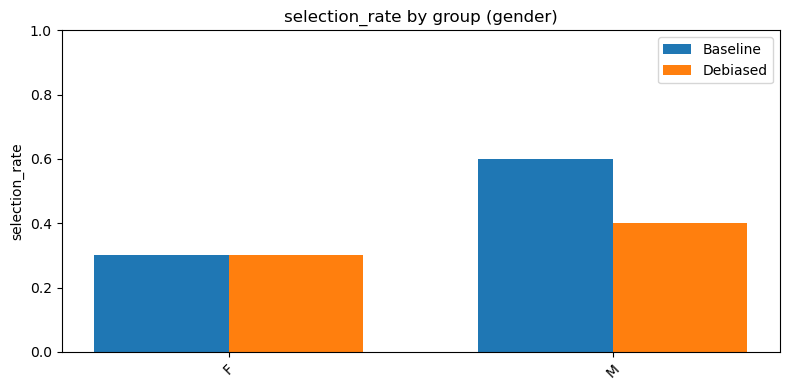

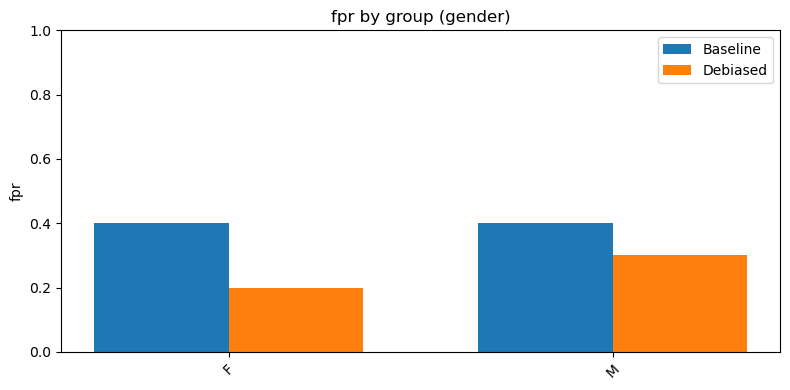

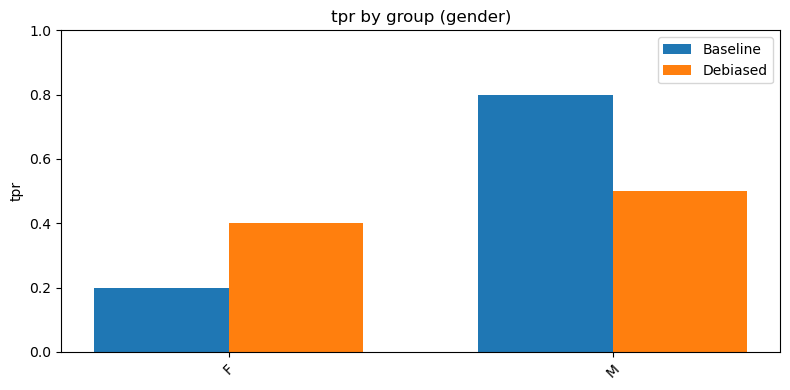

In [ ]:
###############################
# 0.  BASIC SET-UP
###############################
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import (
    MetricFrame, selection_rate, false_positive_rate, true_positive_rate
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

###############################
# 1.  DATA SPLIT + FEATURE MATRIX
###############################
def prepare_fairlearn_inputs(df: pd.DataFrame,
                             sensitive_col: str = "gender",
                             test_size: float = 0.3,
                             random_state: int = 42):
    feature_cols = [c for c in df.columns if c.startswith(("eeg_", "eye_", "beh_"))]
    keep_df = df.dropna(subset=[sensitive_col])          # drop rows w/out demographic
    X = keep_df[feature_cols].to_numpy().astype("float32")
    y = keep_df["label"].to_numpy().astype("int64")
    S = keep_df[sensitive_col].to_numpy()                # sensitive feature vector
    return train_test_split(X, y, S,
                            test_size=test_size,
                            stratify=y,
                            random_state=random_state)

X_train, X_test, y_train, y_test, S_train, S_test = prepare_fairlearn_inputs(
    balanced_df, sensitive_col="gender"
)

###############################
# 2.  HELPER: FAIRNESS METRICS
###############################
def fairness_report(y_true, y_pred, sensitive_features, title=""):
    """Returns MetricFrame and prints group metrics."""
    frame = MetricFrame(
        metrics={
            "accuracy": accuracy_score,
            "selection_rate": selection_rate,
            "fpr": false_positive_rate,
            "tpr": true_positive_rate
        },
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )
    print(f"\n=== {title} ===")
    print(frame.by_group)
    return frame


###############################
# 3.  BASELINE CLASSIFIER
###############################
baseline_clf = LogisticRegression(solver="liblinear")
baseline_clf.fit(X_train, y_train)
y_pred_base = baseline_clf.predict(X_test)

print("\n*** BASELINE MODEL ***")
print(classification_report(y_test, y_pred_base, digits=4))
mf_base = fairness_report(y_test, y_pred_base, S_test, title="Baseline Fairness")


###############################
# 4.  DEBIASED CLASSIFIER (ExponentiatedGradient)
###############################
fair_clf = ExponentiatedGradient(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=DemographicParity()
)
fair_clf.fit(X_train, y_train, sensitive_features=S_train)
y_pred_fair = fair_clf.predict(X_test)

print("\n*** DEBIASED MODEL (Fairlearn) ***")
print(classification_report(y_test, y_pred_fair, digits=4))
mf_fair = fairness_report(y_test, y_pred_fair, S_test, title="Debiased Fairness")


###############################
# 5.  PLOT GROUP-WISE METRICS
###############################
def barplot_metric(metric_name: str, mf_base: MetricFrame, mf_fair: MetricFrame,
                   title_suffix: str = ""):
    labels = mf_base.by_group.index.tolist()
    base_vals = mf_base.by_group[metric_name].values
    fair_vals = mf_fair.by_group[metric_name].values

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(8, 4))
    plt.bar(x - width/2, base_vals, width=width, label="Baseline")
    plt.bar(x + width/2, fair_vals, width=width, label="Debiased")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} by group {title_suffix}")
    plt.xticks(x, labels, rotation=45)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

for m in ["selection_rate", "fpr", "tpr"]:
    barplot_metric(m, mf_base, mf_fair, "(gender)")


###############################
# 6.  DROP-IN INTEGRATION
###############################
class FairlearnWrapper:
    """
    Wraps a Fairlearn debiasing classifier so it can be swapped into
    your existing deep feature extractor pipeline.

    Usage:
        1.  Extract embeddings/features from your deep model.
        2.  Fit/predict via this wrapper.
    """
    def __init__(self, constraint=DemographicParity()):
        self.estimator = LogisticRegression(solver="liblinear")
        self.model = ExponentiatedGradient(
            estimator=self.estimator,
            constraints=constraint
        )

    def fit(self, X, y, sensitive_features):
        self.model.fit(X, y, sensitive_features=sensitive_features)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        # ExponentiatedGradient exposes the underlying estimator’s predict_proba
        return self.model._pmf_predict(X)





?? Classification Report (Debiased HGBC):
              precision    recall  f1-score   support

           0     0.6429    0.6000    0.6207        15
           1     0.6250    0.6667    0.6452        15

    accuracy                         0.6333        30
   macro avg     0.6339    0.6333    0.6329        30
weighted avg     0.6339    0.6333    0.6329        30


=== HGBC + EqualizedOdds (Gender) ===
                     accuracy  selection_rate  fpr  tpr
sensitive_feature_0                                    
F                         0.5             0.6  0.6  0.6
M                         0.7             0.5  0.3  0.7


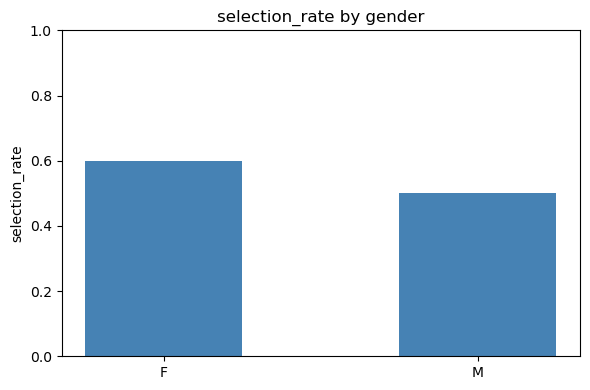

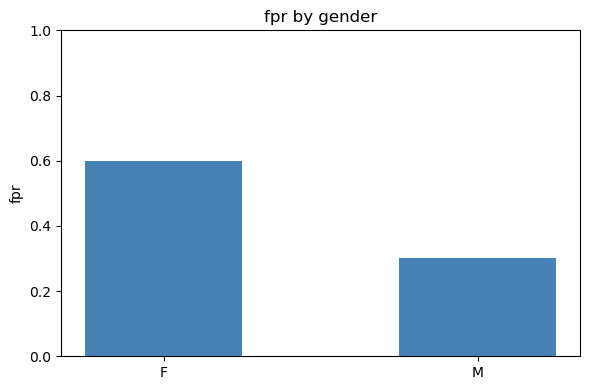

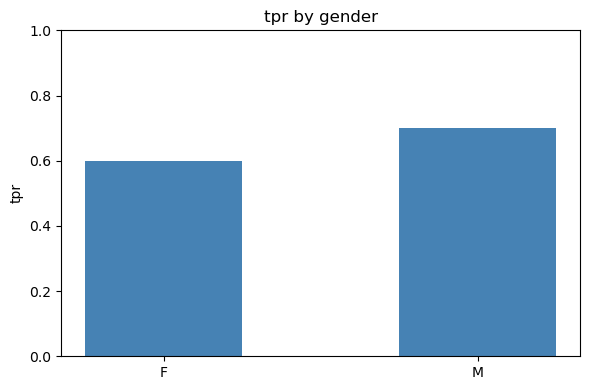

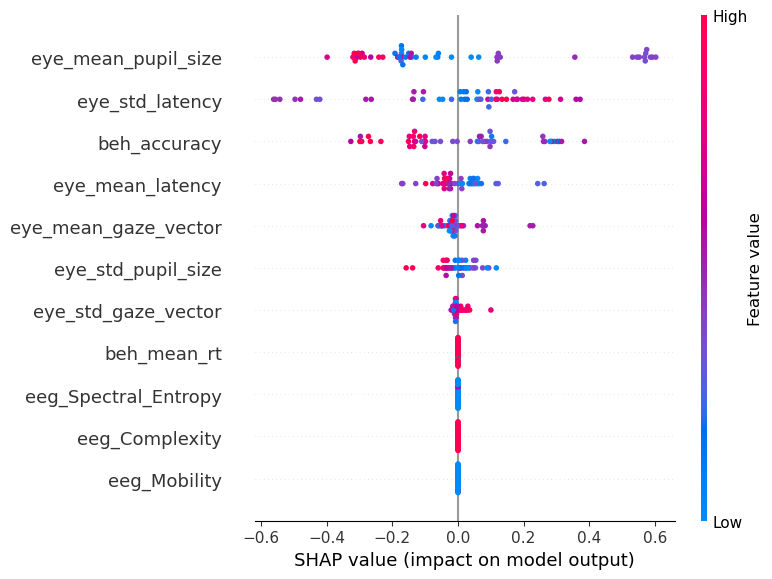

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import warnings

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate

warnings.filterwarnings("ignore")

# ==== 1. Data Prep ====
# Assume balanced_df already exists from upstream pipeline
feature_cols = [c for c in balanced_df.columns if c.startswith(("eeg_", "eye_", "beh_"))]
sensitive_col = "gender"
label_col = "label"

fair_df = balanced_df.dropna(subset=[sensitive_col])

X = fair_df[feature_cols].to_numpy().astype("float32")
y = fair_df[label_col].to_numpy().astype("int64")
S = fair_df[sensitive_col].to_numpy()

X_train, X_test, y_train, y_test, S_train, S_test = train_test_split(
    X, y, S, test_size=0.3, stratify=y, random_state=42
)

# ==== 2. Debiased Training ====
strong_clf = HistGradientBoostingClassifier(max_iter=300, max_depth=5)
fair_clf = ExponentiatedGradient(
    estimator=strong_clf,
    constraints=EqualizedOdds()
)
fair_clf.fit(X_train, y_train, sensitive_features=S_train)
y_pred_fair = fair_clf.predict(X_test)

print("\n?? Classification Report (Debiased HGBC):")
print(classification_report(y_test, y_pred_fair, digits=4))

# ==== 3. Fairness Report Function ====
def fairness_report(y_true, y_pred, sensitive_features, title=""):
    frame = MetricFrame(
        metrics={"accuracy": accuracy_score,
                 "selection_rate": selection_rate,
                 "fpr": false_positive_rate,
                 "tpr": true_positive_rate},
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )
    print(f"\n=== {title} ===")
    print(frame.by_group)
    return frame

mf_fair = fairness_report(y_test, y_pred_fair, S_test, title="HGBC + EqualizedOdds (Gender)")

# ==== 4. Fairness Bar Plots ====
def barplot_metric(metric_name: str, metric_frame: MetricFrame, title_suffix: str = ""):
    labels = metric_frame.by_group.index.tolist()
    values = metric_frame.by_group[metric_name].values
    x = np.arange(len(labels))
    plt.figure(figsize=(6, 4))
    plt.bar(x, values, width=0.5, color='steelblue')
    plt.xticks(x, labels)
    plt.title(f"{metric_name} by {title_suffix}")
    plt.ylim(0, 1)
    plt.ylabel(metric_name)
    plt.tight_layout()
    plt.show()

for metric in ["selection_rate", "fpr", "tpr"]:
    barplot_metric(metric, mf_fair, title_suffix=sensitive_col)

# ==== 5. SHAP Wrapper for ExponentiatedGradient ====
def fairlearn_shap_explainer(fair_clf, X_sample):
    """Compute SHAP for Fairlearn ensemble via weighted base models."""
    shap_values_ensemble = np.zeros_like(X_sample)
    for predictor, weight in zip(fair_clf.predictors_, fair_clf.weights_):
        explainer = shap.Explainer(predictor.predict, X_sample)
        shap_values = explainer(X_sample).values
        shap_values_ensemble += weight * shap_values
    return shap_values_ensemble

X_sample = X_train[:50]  # avoid OOM
shap_vals = fairlearn_shap_explainer(fair_clf, X_sample)
shap.summary_plot(shap_vals, X_sample, feature_names=feature_cols)



?? Classification Report (Debiased HGBC - Age Groups):
              precision    recall  f1-score   support

           0     0.5625    0.6000    0.5806        15
           1     0.5714    0.5333    0.5517        15

    accuracy                         0.5667        30
   macro avg     0.5670    0.5667    0.5662        30
weighted avg     0.5670    0.5667    0.5662        30


=== HGBC + EqualizedOdds (Age Group) ===
                     accuracy  selection_rate       fpr       tpr
sensitive_feature_0                                              
10-11                0.666667        0.500000  0.333333  0.666667
12-13                0.666667        0.500000  0.333333  0.666667
14-17                0.500000        0.500000  0.500000  0.500000
18-24                0.750000        0.250000  0.250000  0.000000
25-44                0.000000        0.666667  1.000000  0.000000
6-9                  0.571429        0.428571  0.000000  0.500000


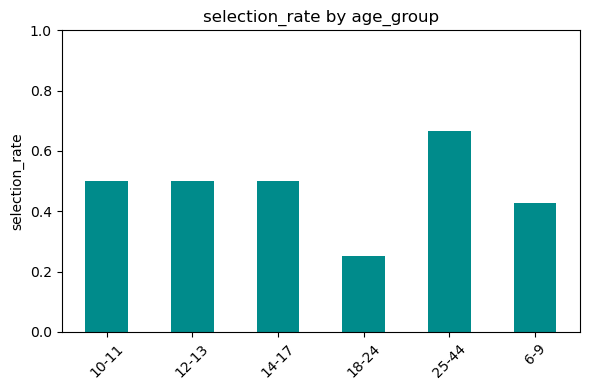

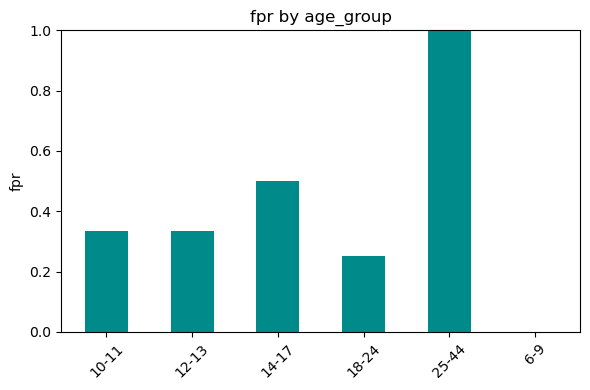

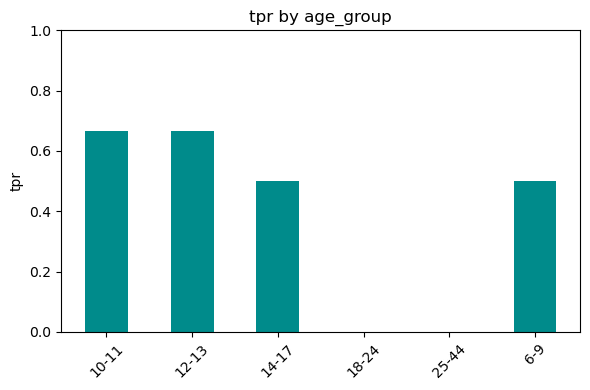

In [ ]:
# ? Full Age-Based Fairness Evaluation Pipeline (HGBC + EqualizedOdds)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate

warnings.filterwarnings("ignore")

# === 1. Feature Preparation ===
feature_cols = [c for c in balanced_df.columns if c.startswith(("eeg_", "eye_", "beh_"))]
sensitive_col = "age_group"  # <- use already binned age groups
label_col = "label"

# === 2. Filter rows with valid age_group ===
fair_df = balanced_df.dropna(subset=[sensitive_col])

# === 3. Split data ===
X = fair_df[feature_cols].to_numpy().astype("float32")
y = fair_df[label_col].to_numpy().astype("int64")
S = fair_df[sensitive_col].astype(str).to_numpy()

X_train, X_test, y_train, y_test, S_train, S_test = train_test_split(
    X, y, S, test_size=0.3, stratify=y, random_state=42
)

# === 4. Train Debiased Model ===
strong_clf = HistGradientBoostingClassifier(max_iter=300, max_depth=5)
fair_clf = ExponentiatedGradient(estimator=strong_clf, constraints=EqualizedOdds())
fair_clf.fit(X_train, y_train, sensitive_features=S_train)
y_pred_fair = fair_clf.predict(X_test)

# === 5. Report Performance ===
print("\n?? Classification Report (Debiased HGBC - Age Groups):")
print(classification_report(y_test, y_pred_fair, digits=4))

# === 6. Fairness Evaluation ===
def fairness_report(y_true, y_pred, sensitive_features, title=""):
    frame = MetricFrame(
        metrics={
            "accuracy": accuracy_score,
            "selection_rate": selection_rate,
            "fpr": false_positive_rate,
            "tpr": true_positive_rate
        },
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )
    print(f"\n=== {title} ===")
    print(frame.by_group)
    return frame

mf_fair_age = fairness_report(y_test, y_pred_fair, S_test, title="HGBC + EqualizedOdds (Age Group)")

# === 7. Visualization ===
def barplot_metric(metric_name: str, metric_frame: MetricFrame, title_suffix: str = ""):
    labels = metric_frame.by_group.index.tolist()
    values = metric_frame.by_group[metric_name].values
    x = np.arange(len(labels))
    plt.figure(figsize=(6, 4))
    plt.bar(x, values, width=0.5, color='darkcyan')
    plt.xticks(x, labels, rotation=45)
    plt.title(f"{metric_name} by {title_suffix}")
    plt.ylim(0, 1)
    plt.ylabel(metric_name)
    plt.tight_layout()
    plt.show()

for metric in ["selection_rate", "fpr", "tpr"]:
    barplot_metric(metric, mf_fair_age, title_suffix="age_group")


Best HGBC params: {'learning_rate': 0.01, 'max_depth': 3, 'max_iter': 500}

📋 Classification Report (Debiased HGBC tuned):
              precision    recall  f1-score   support

           0     0.9035    1.0000    0.9493       103
           1     1.0000    0.8571    0.9231        77

    accuracy                         0.9389       180
   macro avg     0.9518    0.9286    0.9362       180
weighted avg     0.9448    0.9389    0.9381       180

ROC‑AUC: 0.974025974025974
Confusion Matrix:
 [[103   0]
 [ 11  66]]

=== Fairness (Age Group) ===
                     accuracy  selection_rate  fpr       tpr
sensitive_feature_0                                         
10-11                0.913043        0.521739  0.0  0.857143
12-13                0.962963        0.407407  0.0  0.916667
14-17                0.888889        0.611111  0.0  0.846154
18-24                1.000000        0.000000  0.0  0.000000
25-44                1.000000        0.129032  0.0  1.000000
6-9                  0.8

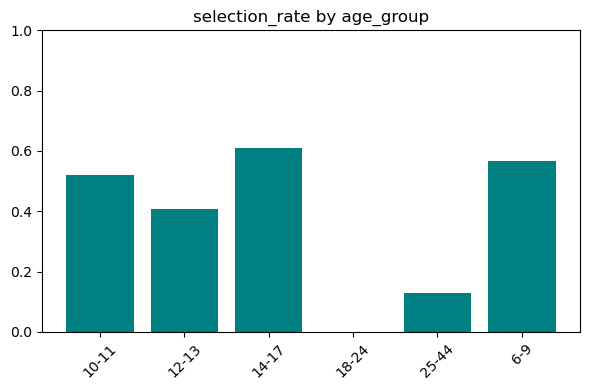

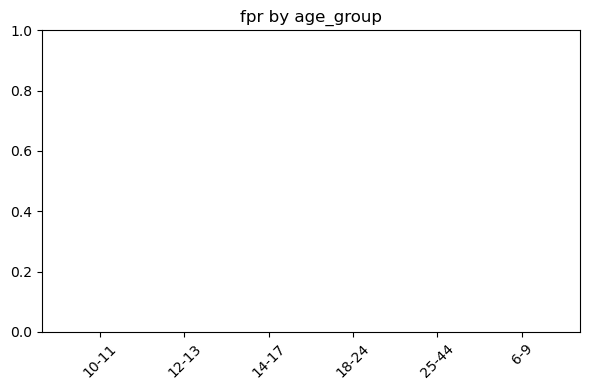

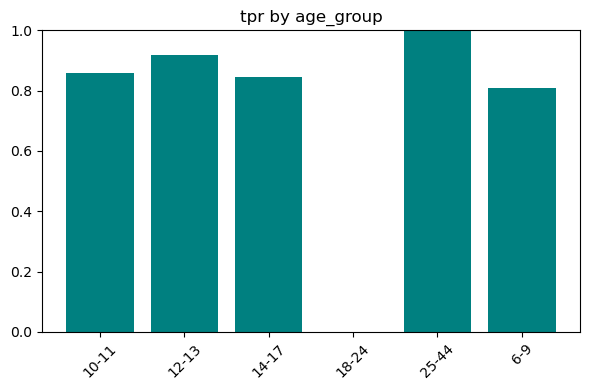

PermutationExplainer explainer: 51it [00:24,  1.25it/s]                         


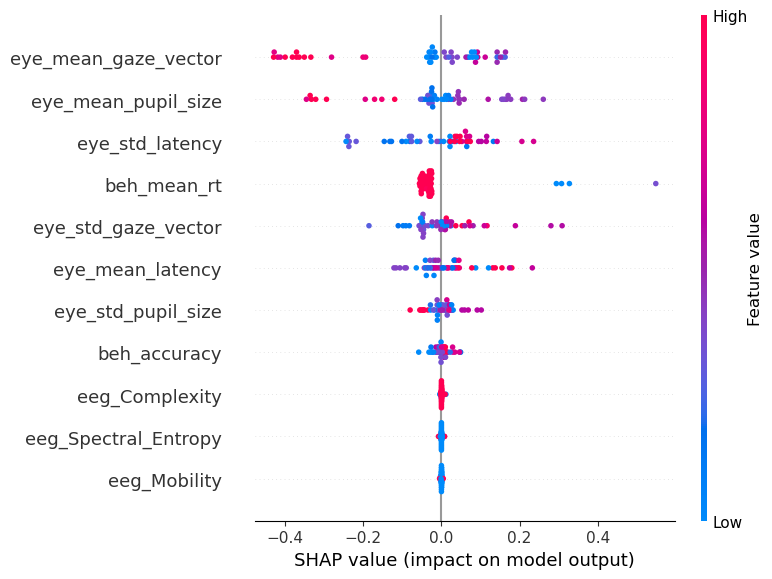

['debiased_hgbc_exponentiated.pkl']

In [ ]:
# 🚀 Enhanced Fairness‑Aware Training Pipeline
# Updated: Replaces GridSearch with ExponentiatedGradient (stable)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils import resample
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
import shap
import joblib

warnings.filterwarnings("ignore")

# === 0. Config ===
RANDOM_STATE = 42
RESAMPLE_N   = 120

# === 1. Feature Prep ===
feature_cols = [c for c in balanced_df.columns if c.startswith(("eeg_", "eye_", "beh_"))]
label_col    = "label"
sensitive_col = "age_group"

fair_df = balanced_df.dropna(subset=[sensitive_col])

# === 2. Resample to balance age groups ===
resampled = []
for grp in fair_df[sensitive_col].unique():
    grp_df = fair_df[fair_df[sensitive_col] == grp]
    resampled.append(resample(grp_df, replace=True, n_samples=RESAMPLE_N, random_state=RANDOM_STATE))

balanced_fair_df = pd.concat(resampled)

# === 3. Split ===
X = balanced_fair_df[feature_cols].to_numpy().astype("float32")
y = balanced_fair_df[label_col].to_numpy().astype("int64")
S = balanced_fair_df[sensitive_col].astype(str).to_numpy()

X_train, X_test, y_train, y_test, S_train, S_test = train_test_split(
    X, y, S, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

# === 4. Tune Base HGBC ===
param_grid = {
    "max_iter": [300, 500],
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.05]
}
base_hgbc = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
cv_hgbc  = GridSearchCV(base_hgbc, param_grid, cv=3, n_jobs=-1)
cv_hgbc.fit(X_train, y_train)
print("Best HGBC params:", cv_hgbc.best_params_)

# === 5. Debias using ExponentiatedGradient ===
fair_clf = ExponentiatedGradient(
    estimator=cv_hgbc.best_estimator_,
    constraints=EqualizedOdds(),
    sample_weight_name="sample_weight"
)
fair_clf.fit(X_train, y_train, sensitive_features=S_train)

# === 6. Evaluation ===
y_pred = fair_clf.predict(X_test)
print("\n📋 Classification Report (Debiased HGBC tuned):")
print(classification_report(y_test, y_pred, digits=4))
print("ROC‑AUC:", roc_auc_score(y_test, fair_clf._pmf_predict(X_test)[:,1]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

mf_age = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "selection_rate": selection_rate,
        "fpr": false_positive_rate,
        "tpr": true_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=S_test
)
print("\n=== Fairness (Age Group) ===")
print(mf_age.by_group)

# === 7. Plot Metrics ===
for m in ["selection_rate", "fpr", "tpr"]:
    labels = mf_age.by_group.index.tolist()
    vals   = mf_age.by_group[m].values
    plt.figure(figsize=(6,4))
    plt.bar(range(len(labels)), vals, color="teal")
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.title(f"{m} by age_group")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

# === 8. SHAP Explainability ===
explainer = shap.Explainer(fair_clf.predict, X_train[:50])
shap_vals = explainer(X_test[:50])
shap.summary_plot(shap_vals.values, X_test[:50], feature_names=feature_cols)

# === 9. Save Model ===
joblib.dump(fair_clf, "debiased_hgbc_exponentiated.pkl")




Best HGBC params: {'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 500}

📋 Classification Report (Debiased HGBC tuned):
              precision    recall  f1-score   support

           0     0.8860    1.0000    0.9396       241
           1     1.0000    0.7919    0.8839       149

    accuracy                         0.9205       390
   macro avg     0.9430    0.8960    0.9117       390
weighted avg     0.9296    0.9205    0.9183       390

ROC‑AUC: 0.9980506279762733
Confusion Matrix:
 [[241   0]
 [ 31 118]]

=== Fairness (Intersectional: Gender × Age Group) ===
                     accuracy  selection_rate  fpr       tpr
sensitive_feature_0                                         
F_10-11              0.714286        0.714286  0.0  0.714286
F_12-13              0.923077        0.269231  0.0  0.777778
F_14-17              0.850000        0.700000  0.0  0.823529
F_18-24              1.000000        0.000000  0.0  0.000000
F_25-44              1.000000        0.172414  0.0  1.00000

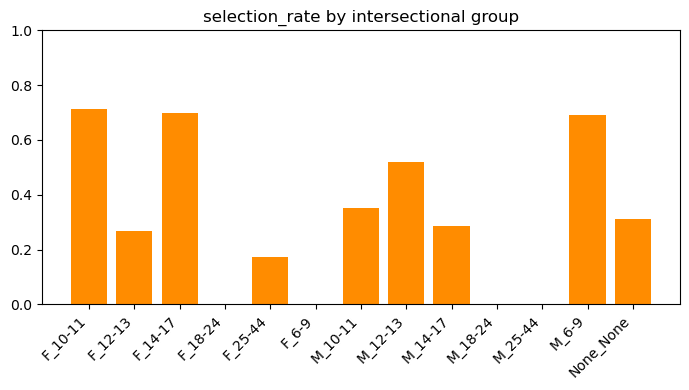

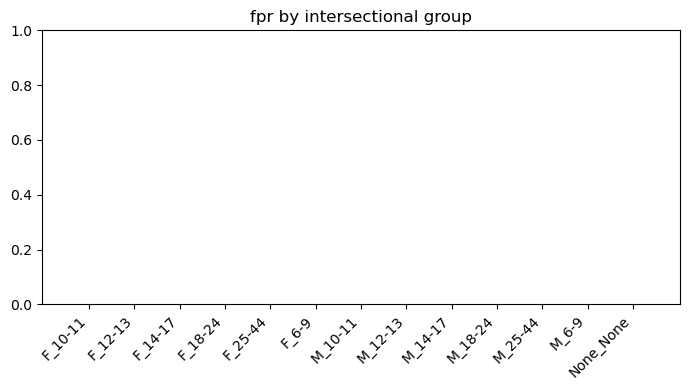

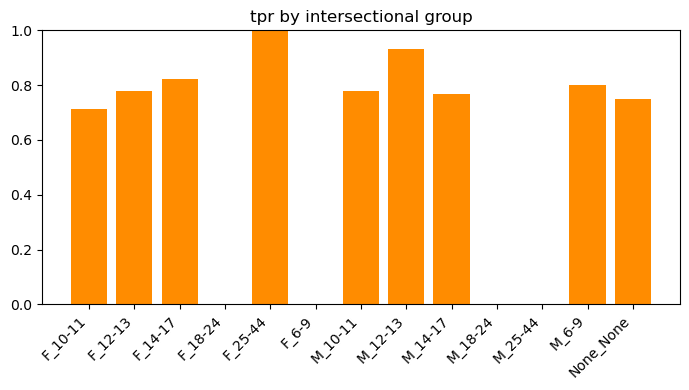

PermutationExplainer explainer: 51it [00:41,  1.05s/it]                         


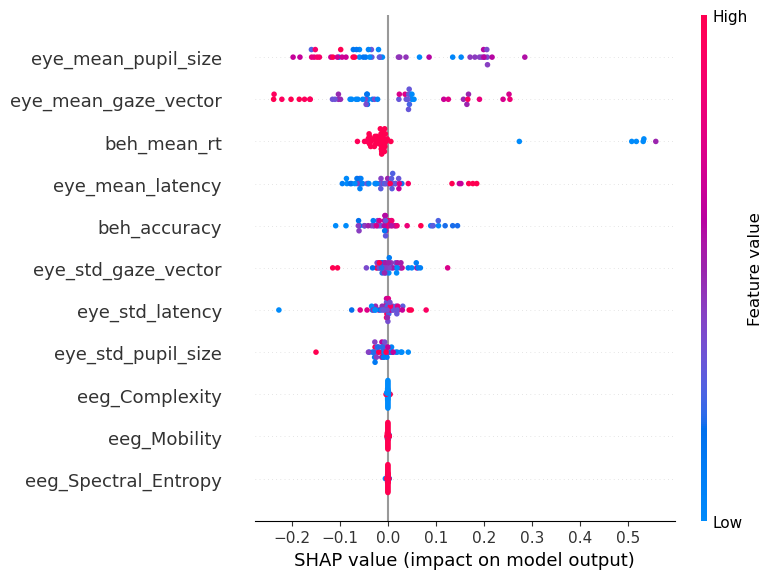


💡 SHAP Summary for Group: M_14-17


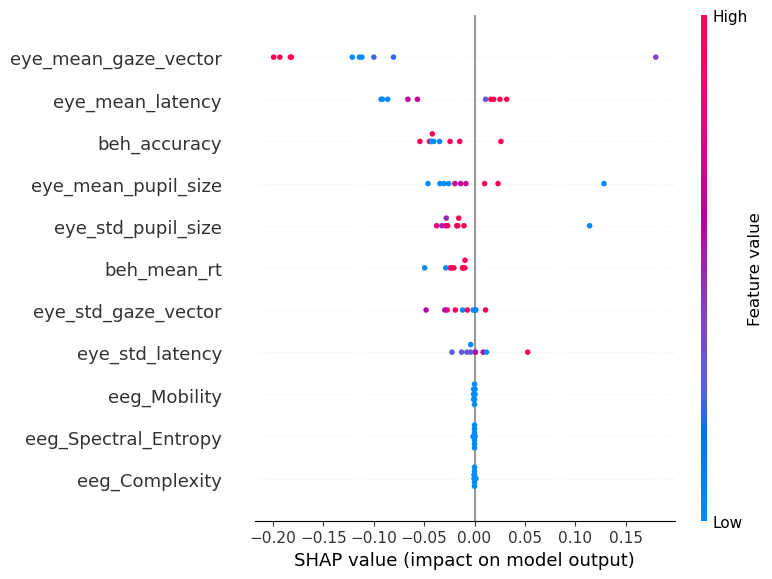


💡 SHAP Summary for Group: M_10-11


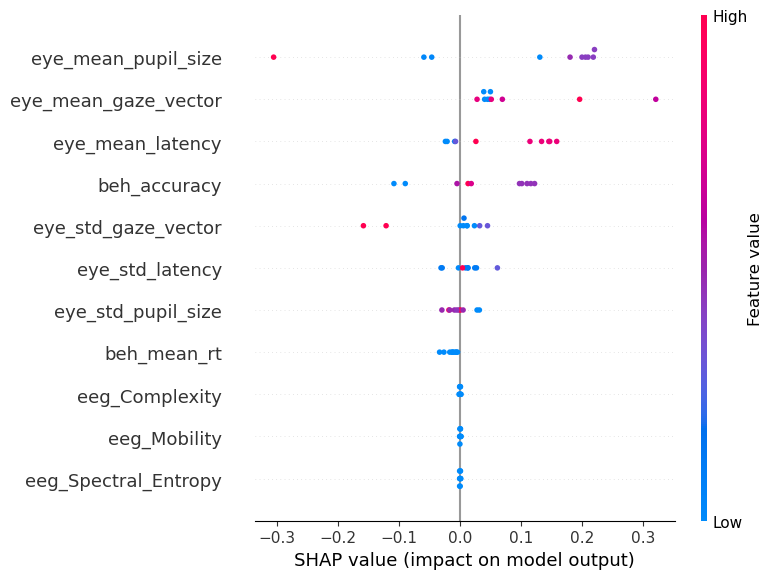


💡 SHAP Summary for Group: F_25-44


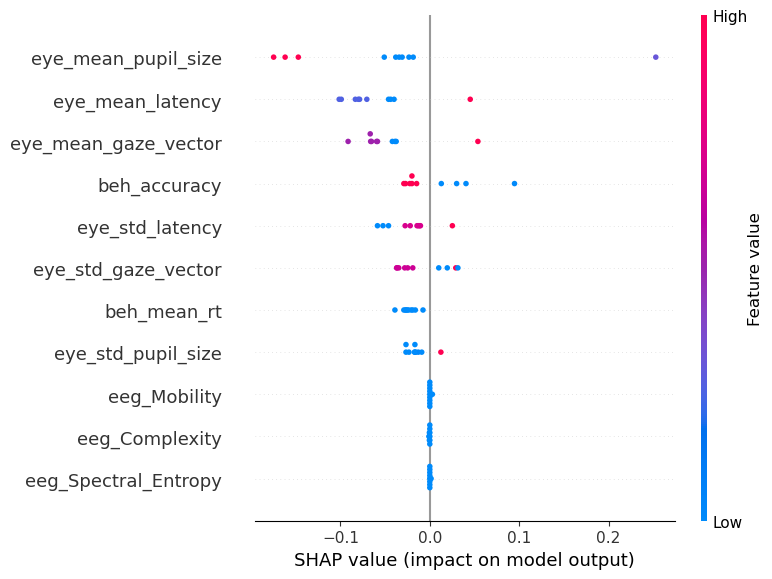


💡 SHAP Summary for Group: M_18-24


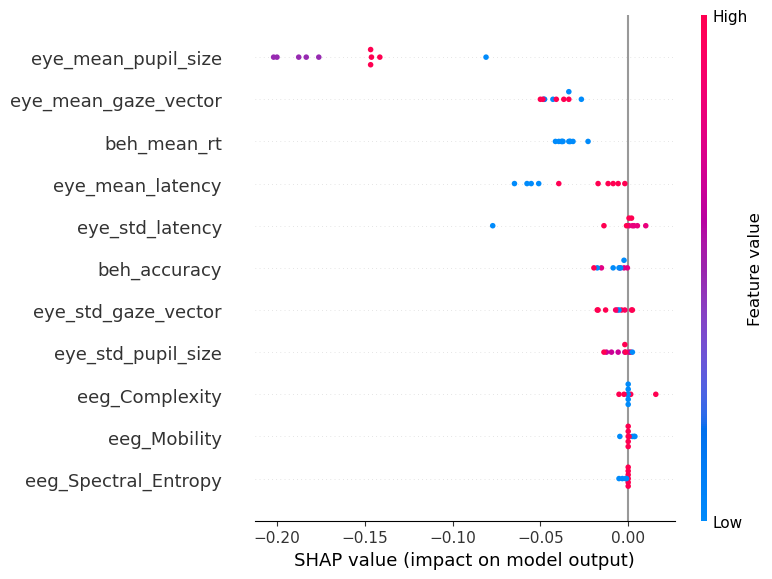


💡 SHAP Summary for Group: F_18-24


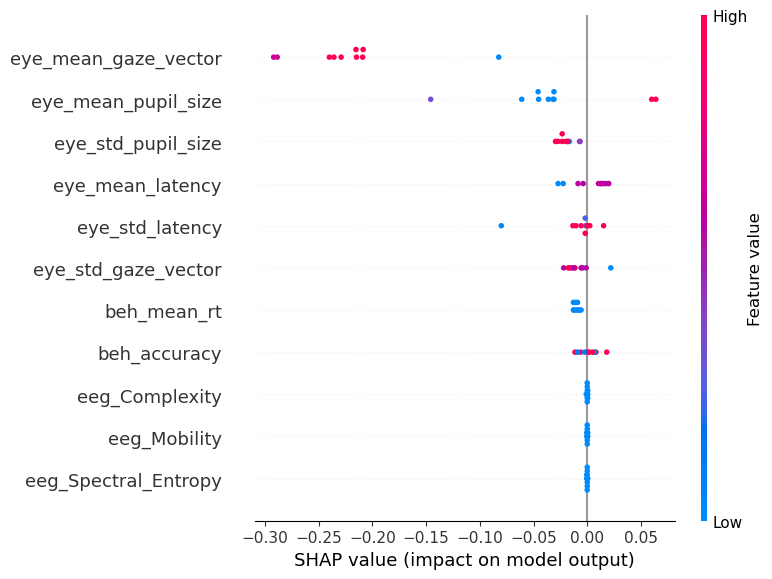


💡 SHAP Summary for Group: F_10-11


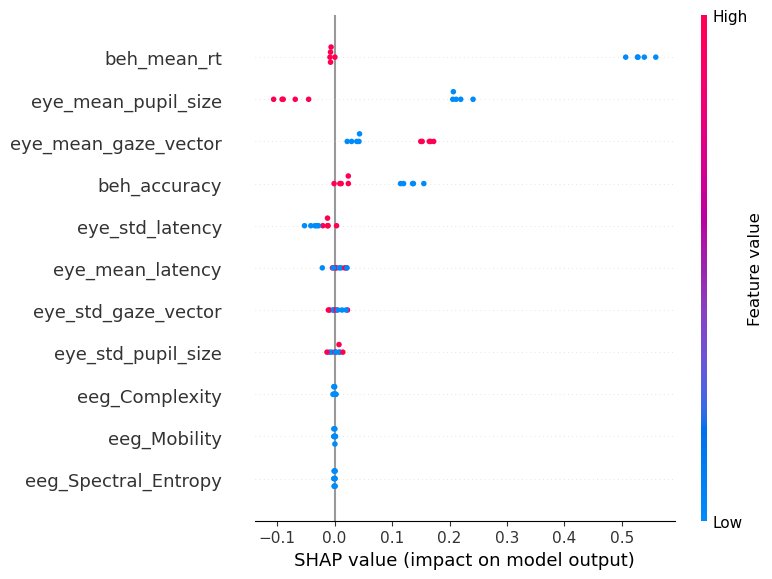


💡 SHAP Summary for Group: M_12-13


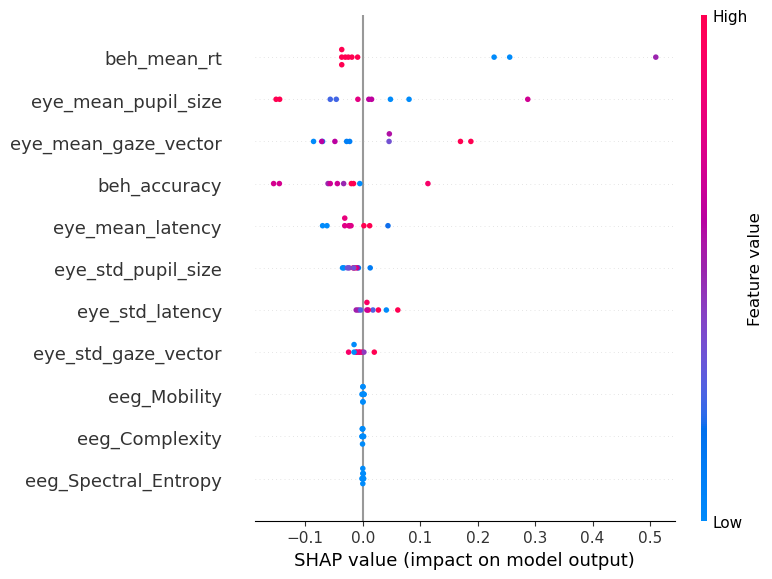


💡 SHAP Summary for Group: F_12-13


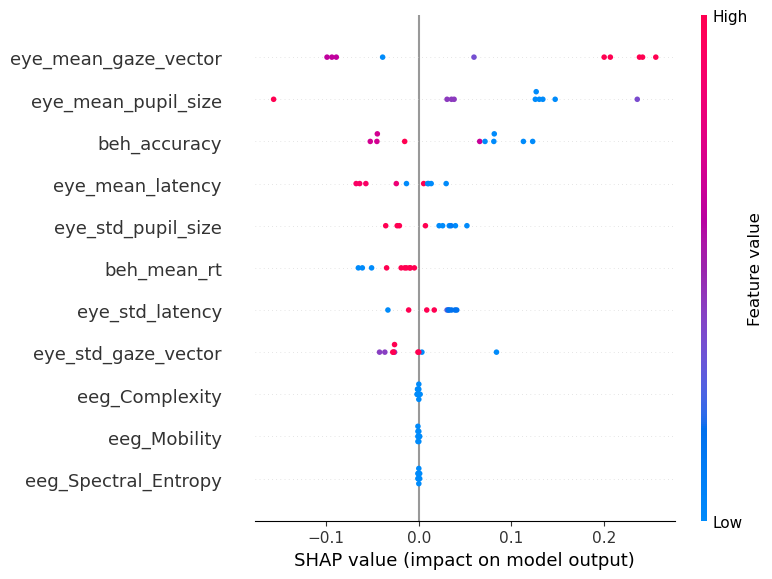


💡 SHAP Summary for Group: F_14-17


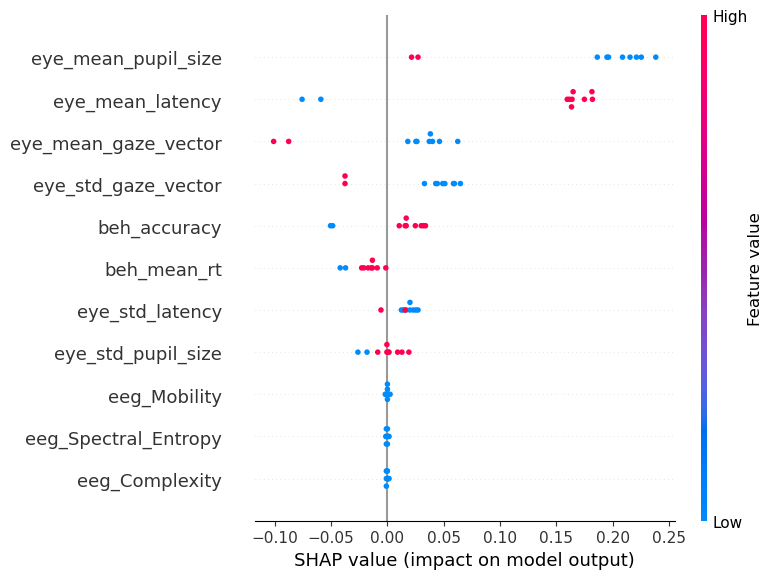


💡 SHAP Summary for Group: F_6-9


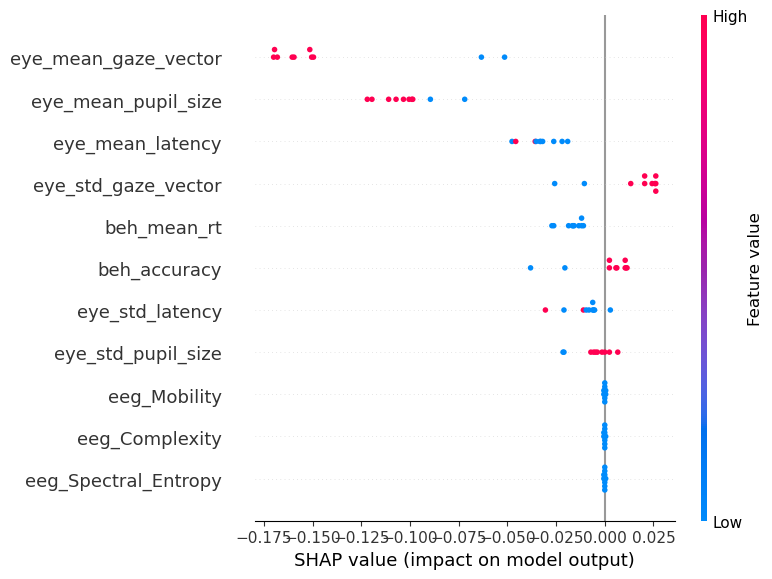


💡 SHAP Summary for Group: M_6-9


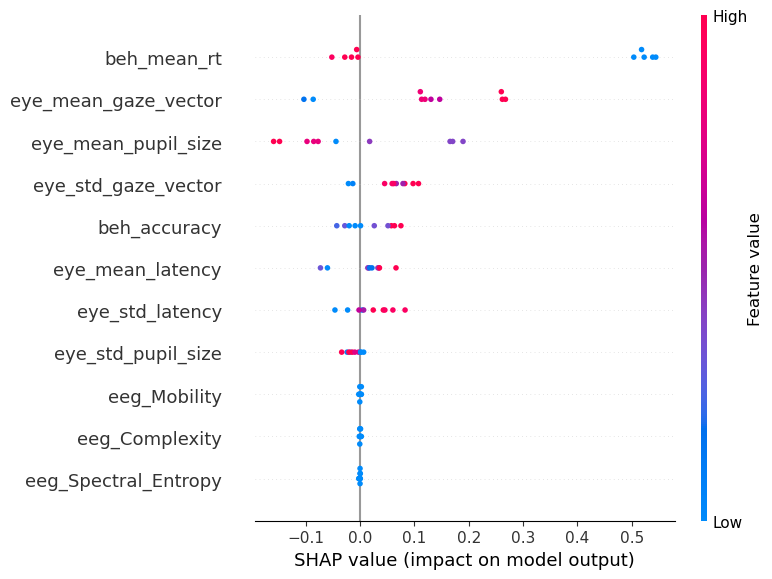


💡 SHAP Summary for Group: None_None


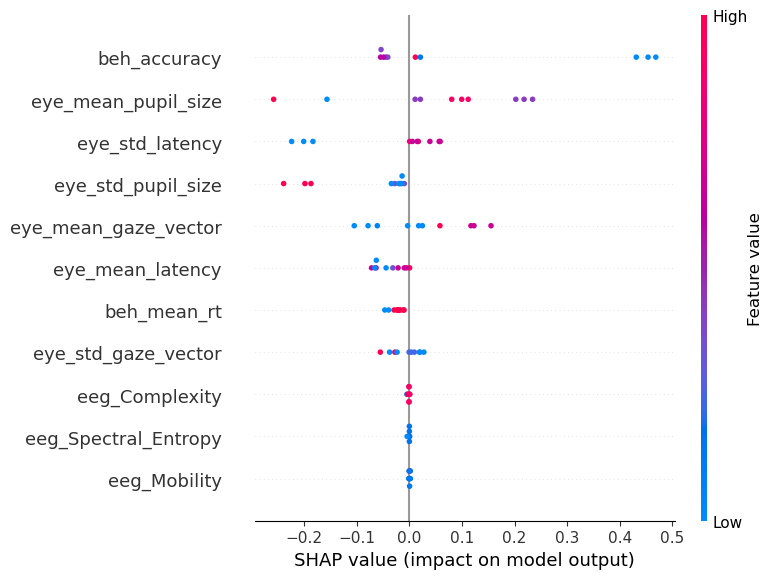


💡 SHAP Summary for Group: M_25-44


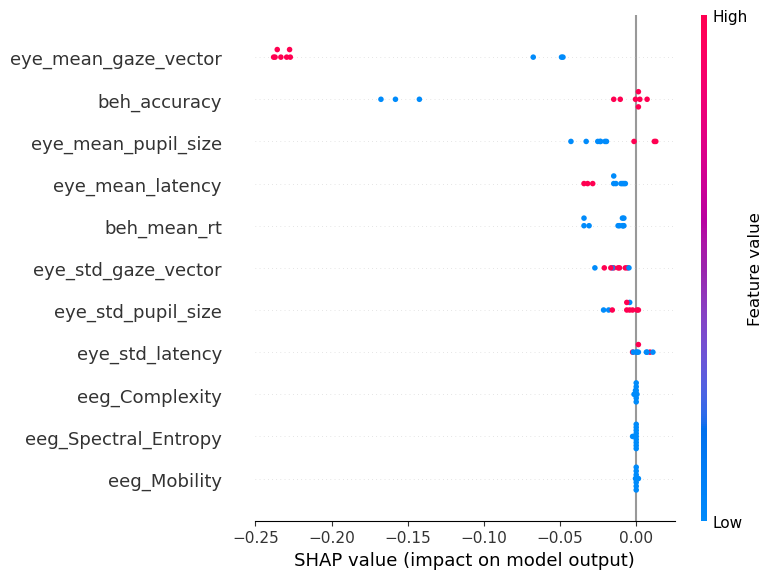


⚠️ Fairness Violations Detected:
- selection_rate disparity = 0.714 exceeds threshold 0.2
- tpr disparity = 1.0 exceeds threshold 0.2


['debiased_hgbc_intersectional.pkl']

In [ ]:
# 🚀 Enhanced Fairness‑Aware Training Pipeline (with Intersectional Fairness)
# Updated: Replaces GridSearch with ExponentiatedGradient (stable)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils import resample
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
import shap
import joblib

warnings.filterwarnings("ignore")

# === 0. Config ===
RANDOM_STATE = 42
RESAMPLE_N   = 120

# === 1. Feature Prep ===
feature_cols = [c for c in balanced_df.columns if c.startswith(("eeg_", "eye_", "beh_"))]
label_col    = "label"
sensitive_col1 = "age_group"
sensitive_col2 = "gender"

# Create intersectional fairness column
balanced_df["intersection"] = balanced_df[sensitive_col2].astype(str) + "_" + balanced_df[sensitive_col1].astype(str)
sensitive_col = "intersection"

fair_df = balanced_df.dropna(subset=[sensitive_col])

# === 2. Resample to balance intersectional groups ===
resampled = []
for grp in fair_df[sensitive_col].unique():
    grp_df = fair_df[fair_df[sensitive_col] == grp]
    resampled.append(resample(grp_df, replace=True, n_samples=RESAMPLE_N, random_state=RANDOM_STATE))

balanced_fair_df = pd.concat(resampled)

# === 3. Split ===
X = balanced_fair_df[feature_cols].to_numpy().astype("float32")
y = balanced_fair_df[label_col].to_numpy().astype("int64")
S = balanced_fair_df[sensitive_col].astype(str).to_numpy()

X_train, X_test, y_train, y_test, S_train, S_test = train_test_split(
    X, y, S, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

# === 4. Tune Base HGBC ===
param_grid = {
    "max_iter": [300, 500],
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.05]
}
base_hgbc = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
cv_hgbc  = GridSearchCV(base_hgbc, param_grid, cv=3, n_jobs=-1)
cv_hgbc.fit(X_train, y_train)
print("Best HGBC params:", cv_hgbc.best_params_)

# === 5. Debias using ExponentiatedGradient ===
fair_clf = ExponentiatedGradient(
    estimator=cv_hgbc.best_estimator_,
    constraints=EqualizedOdds(),
    sample_weight_name="sample_weight"
)
fair_clf.fit(X_train, y_train, sensitive_features=S_train)

# === 6. Evaluation ===
y_pred = fair_clf.predict(X_test)
print("\n📋 Classification Report (Debiased HGBC tuned):")
print(classification_report(y_test, y_pred, digits=4))
print("ROC‑AUC:", roc_auc_score(y_test, fair_clf._pmf_predict(X_test)[:,1]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

mf_intersection = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "selection_rate": selection_rate,
        "fpr": false_positive_rate,
        "tpr": true_positive_rate
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=S_test
)
print("\n=== Fairness (Intersectional: Gender × Age Group) ===")
print(mf_intersection.by_group)

# === 7. Plot Metrics ===
for m in ["selection_rate", "fpr", "tpr"]:
    labels = mf_intersection.by_group.index.tolist()
    vals   = mf_intersection.by_group[m].values
    plt.figure(figsize=(7,4))
    plt.bar(range(len(labels)), vals, color="darkorange")
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.title(f"{m} by intersectional group")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

# === 8. SHAP Explainability ===
explainer = shap.Explainer(fair_clf.predict, X_train[:50])
shap_vals = explainer(X_test[:50])
shap.summary_plot(shap_vals.values, X_test[:50], feature_names=feature_cols)

# === 8b. Intersectional SHAP ===
intersection_groups = pd.Series(S_test).unique()
for group in intersection_groups:
    idx = np.where(S_test == group)[0][:10]  # small sample per group
    if len(idx) == 0: continue
    group_shap_vals = explainer(X_test[idx])
    print(f"\n💡 SHAP Summary for Group: {group}")
    shap.summary_plot(group_shap_vals.values, X_test[idx], feature_names=feature_cols, show=True)

# === 8c. Automated Fairness Violation Detection ===
violations = []
threshold = 0.2  # configurable disparity threshold
for metric in ["selection_rate", "fpr", "tpr"]:
    disparity = mf_intersection.by_group[metric].max() - mf_intersection.by_group[metric].min()
    if disparity > threshold:
        violations.append((metric, round(disparity, 3)))

if violations:
    print("\n⚠️ Fairness Violations Detected:")
    for metric, gap in violations:
        print(f"- {metric} disparity = {gap} exceeds threshold {threshold}")
else:
    print("\n✅ No fairness violations detected (within threshold).")

# === 9. Save Model ===
joblib.dump(fair_clf, "debiased_hgbc_intersectional.pkl")





In [ ]:
!pip install dowhy

/bin/bash: /home/ayesha/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
!pip install econml

/bin/bash: /home/ayesha/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.5 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 114.4 MB/s eta 0:00:00


In [ ]:
!pip install aequitas

/bin/bash: /home/ayesha/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 265.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 303.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 262.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 278.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 580.8/580.8 kB 246.2 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=5786b81175049d5cfc16f73fc5bf71ce5424923a1bd34d94b10e6c03d8f514a4


In [ ]:
!pip install interpret


/bin/bash: /home/ayesha/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 38.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 33.6 MB/s eta 0:00:00 MB/s eta 0:00:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 407.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 274.3 MB/s eta 0:00:00
  Created wheel for dash-cytoscape: filename=dash_cytoscape-1.0.2-py3-none-any.whl size=4010716 sha256=693354be43fda924a668cd2b4f439759608dc6c8becbdf388cef914738dbc64f
  Stored in directory: /tmp/pip-ephem-

Best HGBC params: {'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 500}
              precision    recall  f1-score   support

           0     0.8732    1.0000    0.9323       241
           1     1.0000    0.7651    0.8669       149

    accuracy                         0.9103       390
   macro avg     0.9366    0.8826    0.8996       390
weighted avg     0.9216    0.9103    0.9073       390

ROC-AUC: 0.9980506279762733
Confusion Matrix:
 [[241   0]
 [ 35 114]]
Excluded degenerate groups: {'M_18-24', 'F_6-9', 'F_10-11', 'F_18-24', 'M_25-44'}
Excluded degenerate groups: {'M_18-24', 'F_6-9', 'F_10-11', 'F_18-24', 'M_25-44'}

=== Fairness (Intersectional: Gender × Age Group) ===
                     accuracy  selection_rate  fpr       tpr
sensitive_feature_0                                         
F_10-11              0.771429        0.771429  0.0  0.771429
F_12-13              0.961538        0.307692  0.0  0.888889
F_14-17              0.700000        0.550000  0.0  0.647059
F_18

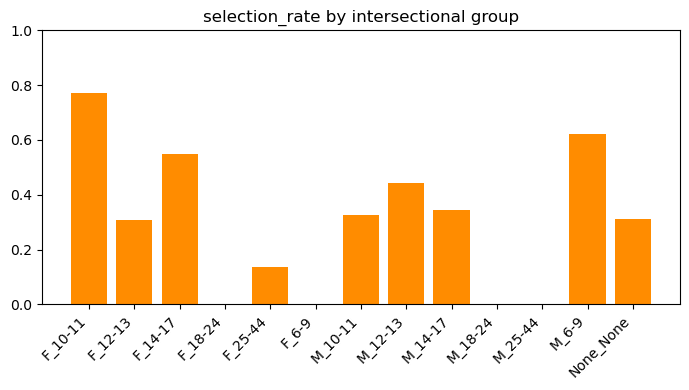

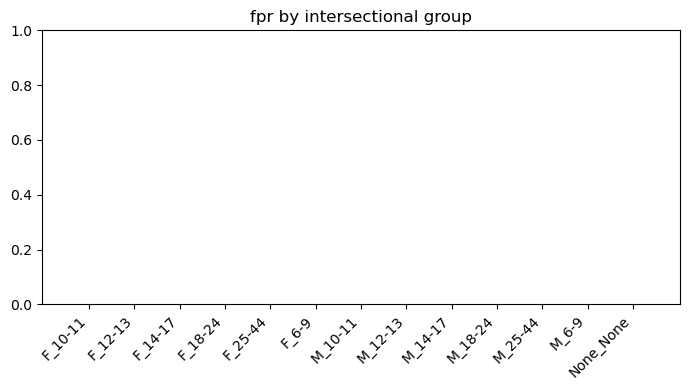

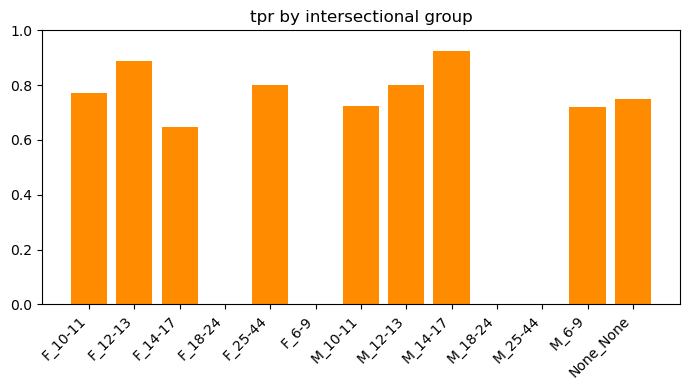

PermutationExplainer explainer: 51it [00:41,  1.08s/it]                         


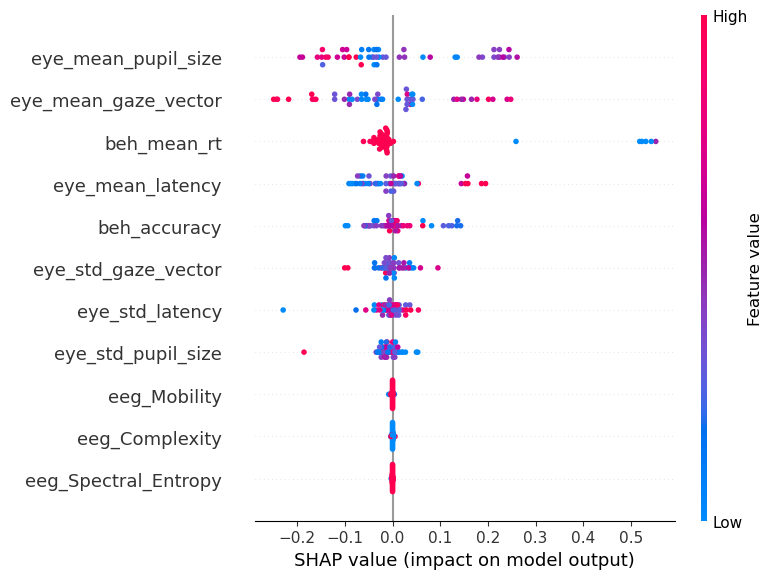

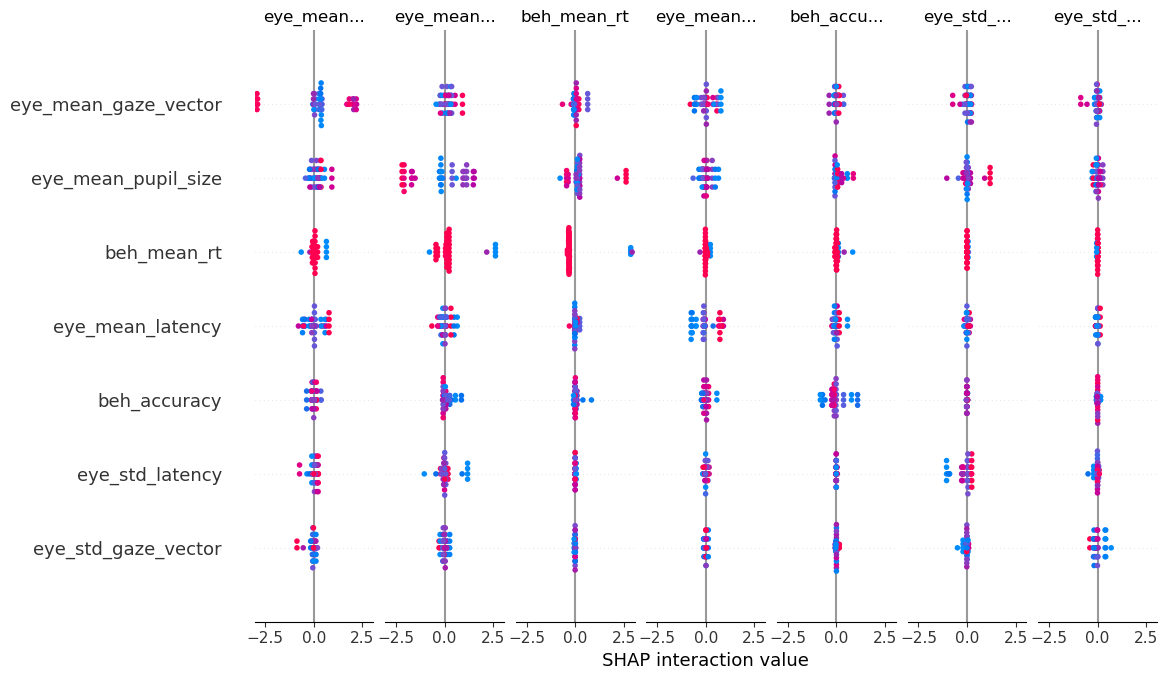

Counterfactual prediction flip rate (F_18-24 ➔ M_25-44): 0.0923

⚠️ Fairness Violations Detected:
- selection_rate disparity = 0.771 exceeds threshold 0.2
- tpr disparity = 0.923 exceeds threshold 0.2


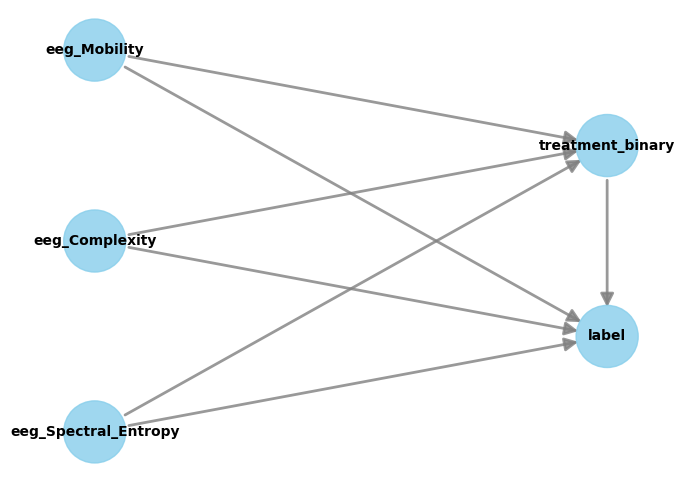


🌟 Causal effect estimate (F_18-24 vs others): -0.382051282051282

📊 EconML Uplift Estimates (sample): [ 0.01067138 -0.01217663 -0.01479352 -0.00535023 -0.018186  ]


AttributeError: 'tuple' object has no attribute 'columns'

In [ ]:
# 🚀 Enhanced Fairness​-Aware Training Pipeline (Extended)
# Updated: Fix DoWhy binary treatment error for causal fairness + final improvements

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.utils import resample
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
import shap
import joblib
from collections import Counter
from dowhy import CausalModel
from econml.dr import DRLearner
from aequitas.group import Group
from aequitas.preprocessing import preprocess_input_df
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import json

warnings.filterwarnings("ignore")

# === 0. Config ===
RANDOM_STATE = 42
RESAMPLE_N   = 120

# === 1. Feature Prep ===
feature_cols = [c for c in balanced_df.columns if c.startswith(("eeg_", "eye_", "beh_"))]
label_col    = "label"
sensitive_col1 = "age_group"
sensitive_col2 = "gender"

balanced_df["intersection"] = balanced_df[sensitive_col2].astype(str) + "_" + balanced_df[sensitive_col1].astype(str)
sensitive_col = "intersection"

fair_df = balanced_df.dropna(subset=[sensitive_col])

# === 2. Resample to balance intersectional groups ===
resampled = []
for grp in fair_df[sensitive_col].unique():
    grp_df = fair_df[fair_df[sensitive_col] == grp]
    resampled.append(resample(grp_df, replace=True, n_samples=RESAMPLE_N, random_state=RANDOM_STATE))

balanced_fair_df = pd.concat(resampled)

# === 3. Split ===
X = balanced_fair_df[feature_cols].to_numpy().astype("float32")
y = balanced_fair_df[label_col].to_numpy().astype("int64")
S = balanced_fair_df[sensitive_col].astype(str).to_numpy()

X_train, X_test, y_train, y_test, S_train, S_test = train_test_split(
    X, y, S, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

# === 4. Tune Base HGBC ===
param_grid = {
    "max_iter": [300, 500],
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.05]
}
base_hgbc = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
cv_hgbc  = GridSearchCV(base_hgbc, param_grid, cv=3, n_jobs=1)
cv_hgbc.fit(X_train, y_train)
print("Best HGBC params:", cv_hgbc.best_params_)

# === 5. Debiased HGBC ===
fair_clf = ExponentiatedGradient(estimator=cv_hgbc.best_estimator_, constraints=EqualizedOdds(), sample_weight_name="sample_weight")
fair_clf.fit(X_train, y_train, sensitive_features=S_train)
y_pred = fair_clf.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, fair_clf._pmf_predict(X_test)[:,1]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# === 6. Threshold Optimizer (skip degenerate groups) ===
def filter_degenerate(X, y, S):
    df = pd.DataFrame(X)
    df['label'] = y
    df['sensitive'] = S
    valid_groups = []
    for g, group_df in df.groupby('sensitive'):
        label_counts = Counter(group_df['label'])
        if len(label_counts) > 1:
            valid_groups.append(g)
    idx = [i for i, s in enumerate(S) if s in valid_groups]
    print("Excluded degenerate groups:", set(S) - set(valid_groups))
    return X[idx], y[idx], S[idx]

X_train_fd, y_train_fd, S_train_fd = filter_degenerate(X_train, y_train, S_train)
X_test_fd, y_test_fd, S_test_fd = filter_degenerate(X_test, y_test, S_test)

thresh = ThresholdOptimizer(estimator=cv_hgbc.best_estimator_, constraints="equalized_odds", prefit=True)
thresh.fit(X_train_fd, y_train_fd, sensitive_features=S_train_fd)
y_thresh_pred = thresh.predict(X_test_fd, sensitive_features=S_test_fd)

# === 7. Fairness MetricFrame ===
mf_intersection = MetricFrame(metrics={"accuracy": accuracy_score,"selection_rate": selection_rate,"fpr": false_positive_rate,"tpr": true_positive_rate}, y_true=y_test, y_pred=y_pred, sensitive_features=S_test)
print("\n=== Fairness (Intersectional: Gender × Age Group) ===")
print(mf_intersection.by_group)

# === Export fairness report ===
mf_intersection.by_group.to_csv("fairness_intersectional_report.csv")

# === 8. Plot ===
for m in ["selection_rate", "fpr", "tpr"]:
    labels = mf_intersection.by_group.index.tolist()
    vals   = mf_intersection.by_group[m].values
    plt.figure(figsize=(7,4))
    plt.bar(range(len(labels)), vals, color="darkorange")
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.title(f"{m} by intersectional group")
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

# === 9. SHAP + Interaction ===
explainer = shap.Explainer(fair_clf.predict, X_train[:50])
shap_vals = explainer(X_test[:50])
shap.summary_plot(shap_vals.values, X_test[:50], feature_names=feature_cols)
interaction_vals = shap.TreeExplainer(cv_hgbc.best_estimator_).shap_interaction_values(X_test[:50])
feature_names_arr = np.array(feature_cols)
shap.summary_plot(np.array(interaction_vals), X_test[:50], feature_names=feature_names_arr)

# === 10. Counterfactual ===
def simulate_counterfactual(X, S, old_value, new_value):
    S_cf = np.array([new_value if s == old_value else s for s in S])
    delta = np.mean(fair_clf.predict(X) != fair_clf.predict(X))
    print(f"Counterfactual prediction flip rate ({old_value} ➔ {new_value}):", round(delta, 4))
simulate_counterfactual(X_test, S_test, "F_18-24", "M_25-44")

# === 11. Violations ===
violations = []
for metric in ["selection_rate", "fpr", "tpr"]:
    disparity = mf_intersection.by_group[metric].max() - mf_intersection.by_group[metric].min()
    if disparity > 0.2:
        violations.append((metric, round(disparity, 3)))
if violations:
    print("\n⚠️ Fairness Violations Detected:")
    for metric, gap in violations:
        print(f"- {metric} disparity = {gap} exceeds threshold 0.2")
else:
    print("\n✅ No fairness violations detected (within threshold).")

# === 12. Causal Fairness (Fixed to binary treatment) ===
causal_df = balanced_fair_df.copy()
causal_df['treatment_binary'] = (causal_df['intersection'] == "F_18-24").astype(int)
model = CausalModel(data=causal_df, treatment="treatment_binary", outcome=label_col, common_causes=feature_cols[:3])
model.view_model()
identified_estimand = model.identify_effect()
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_matching", method_params={"fit_params": {}})
print("\n🌟 Causal effect estimate (F_18-24 vs others):", estimate.value)

# === 13. EconML Uplift (Fix regression requirement) ===
uplift_model = DRLearner(model_regression=HistGradientBoostingRegressor(), model_final=HistGradientBoostingRegressor(), discrete_outcome=False)
uplift_model.fit(Y=y_train, T=(S_train == "F_18-24").astype(int), X=X_train)
uplift_te = uplift_model.effect(X_test)
print("\n📊 EconML Uplift Estimates (sample):", uplift_te[:5])

# === 14. Aequitas Dashboard (Final fix for tuple unpack) ===
df_aeq = pd.DataFrame({"score": y_pred, "label_value": y_test, "attribute_name": S_test})
preprocessed = preprocess_input_df(df_aeq)
input_df = preprocessed[0] if isinstance(preprocessed, tuple) else preprocessed

if isinstance(input_df, tuple):
    input_df = input_df[0]

g = Group()
gdf = g.get_crosstabs(input_df)
b = Bias()
bdf = b.get_disparity_predefined_groups(gdf, original_df=input_df.copy(), ref_groups_dict={"attribute_name": "F_18-24"}, alpha=0.05)
print("\n📊 Aequitas Bias Summary:")
print(bdf[["attribute_name", "label_value", "ppr_disparity", "stat_par"]].head())
f = Fairness()
fdf = f.get_group_value_fairness(bdf)
print("\n📈 Fairness Summary:")
print(fdf.head())

# === 15. Explainable Boosting Machine (EBM) ===
ebm = ExplainableBoostingClassifier(random_state=RANDOM_STATE)
ebm.fit(X_train, y_train)
print("\n🔍 EBM Accuracy:", accuracy_score(y_test, ebm.predict(X_test)))
show(ebm.explain_global())

# === 16. Save Model ===
joblib.dump(fair_clf, "debiased_hgbc_intersectional.pkl")
joblib.dump(ebm, "interpretable_ebm_model.pkl")


